In [1]:
import os
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from utils import *
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from concurrent.futures import ThreadPoolExecutor, as_completed
# get some functions for the behavior analyses
import sys
sys.path.append('../behavior')
from fnc_analysis import (two_bottle_plot, cumm_test_licks_plot, check_significance,
                          two_bottle_pref_plot_vl, plot_significance)
sys.path.append('../../photometry-scripts/')
from analysis_pipeline import *
from concurrent.futures import ThreadPoolExecutor, as_completed

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [3]:
#figure settings
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('Set1',10))
mpl.rcParams['svg.fonttype'] = 'none'

In [237]:
# figure save paths
first_lick_pdfs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'pdfs')
first_lick_svgs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'svgs')

peri_stim_pdfs_train =  os.path.join('figures', 'training', 'peri-stim', 'pdfs')
peri_stim_svgs_train =  os.path.join('figures', 'training', 'peri-stim', 'svgs')
peri_stim_train_figs =  os.path.join('figures', 'training', 'peri-stim')

peri_stim_pdfs_test = os.path.join('figures', 'testing', 'peri-stim', 'pdfs')
peri_stim_svgs_test = os.path.join('figures', 'testing', 'peri-stim', 'svgs')
peri_stim_test_figs = os.path.join('figures', 'testing', 'peri-stim')

first_lick_test_pdfs = os.path.join('figures', 'testing', 'full-trace', 'pdfs')
first_lick_test_svgs =  os.path.join('figures', 'testing', 'full-trace',  'svgs')

methods_pdfs = os.path.join('figures', 'methods', 'pdfs')
methods_svgs = os.path.join('figures', 'methods', 'svgs')

fig_paths = [ first_lick_pdfs, first_lick_svgs,
              peri_stim_train_figs,
              peri_stim_pdfs_train, peri_stim_svgs_train,
              peri_stim_test_figs,
              peri_stim_pdfs_test, peri_stim_svgs_test,
              first_lick_test_pdfs, first_lick_test_svgs,
              methods_pdfs, methods_svgs ]

for i in fig_paths:
    os.makedirs(i, exist_ok=True)         


main_train_fig_stats = {}
main_test_fig_stats = {}

In [5]:
# analysis parameters
# preprocessing
ds_freq = 10                              # frequency to downsample to
ex = 10                                   # number of standard deviations beyond which to exclude data points (i.e. artifact)
t_dur = 1800                              # total duration of each session in seconds from spout presentation
norm_method = norm_to_median_pre_stim     # normalization method, see functions in the utilities file in  our photometry scripts
detrend = True                            # whether or not to regress out motion and photobleaching artifact using the 405
detrend_method = detrend_405_constrained  # method for artifact removal. constrained means we only regress out positive correlations between the 470 and 405


# peri-bout
bout_thresh = 20                          # inter-lick-interval threshold for defining a new bout
niters_rand = 100                         # number of iterations over which generate random bouts
peri_window = 20                          # duration in seconds flanking the bout onset to analyze peri-bout responses
peri_bout_norm_train = "none"             # method for normalizing peri-bout responses during training
peri_bout_norm_test  = "none"             # method for normalizing peri-bout responses during testing

# kernel parameters for moving average detrending
w_rad= 30
ksize = int(2* ds_freq * w_rad) + 1
kernel = signal.boxcar(ksize)/ksize

# Training

## load data

In [6]:
# load training data
training = analysis(norm_method, t_dur, 
                    ds_freq = 1, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(Path('data/cohort1/training.npy'))
training.load_append_save(Path('data/cohort2/training.npy'))
training.compute()

loading data from file...
loading data from file...
recomputing...


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divi

successful


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


## some methods plots

### rationale for our constrained detrending method

It's important to remember that the 405 is not exactly the isosbestic point for GCAMP. As a result, it's fairly common for very drastic responses to see calcium dependent deflections in the 405 in the opposite direction of the GCAMP response. AgRP responses are typically quite drastic so this is fairly common in mice with good signal as illustrated below. It's important we are aware of this because the standard procedure for using the 405 to detrend the 490 makes the assumption that any correlation between the 405 and 490 is artifact, when in fact the 405 and 490 will be strongly negatively correlated for strong AgRP response. Another way to think about this is to recognize that when these calcium dependent deflections occur in the 405, one could feasible multiply the 405 by a very negative coefficient and reconstruct the 490 almost exactly. As a result when you fit the 405 to the 490 to obtain a baseline to subtract from the signal, you almost certainly will subtract away a majority of the response. 

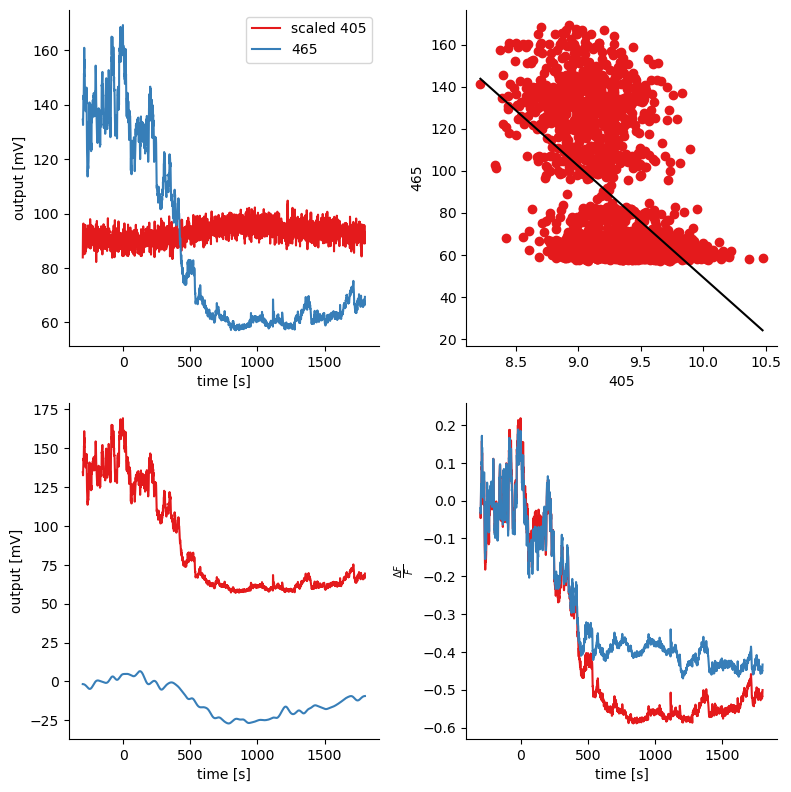

In [8]:
#note we're using the data that's already been normalized for demonstration purposes
raw = deepcopy(training.raw_data.loc['training_2_am','adm480',0])
raw.center_stim()
raw.resample(training.t)

fig, ax = plt.subplots(2,2, figsize = (8,8))

f4 = raw.F490
f5 = raw.F405
ax[0,0].plot(raw.t, 10*f5, label = 'scaled 405')
ax[0,0].plot(raw.t, f4, label = '465')
ax[0,0].legend()
ax[0,0].set_ylabel('output [mV]')
ax[0,0].set_xlabel('time [s]')


ax[0,1].scatter(f5, f4)
ax[0,1].set_xlabel('405')
ax[0,1].set_ylabel('465')


m,b = np.polyfit(f5, f4, 1)
ax[0,1].plot(np.sort(f5), m*np.sort(f5) + b, c = 'k')

base = pd.Series(gaussian_filter1d(m*f5 + b, sigma = 20), index = raw.t)
base -= np.median(base.loc[:0])
ax[1,0].plot(raw.t, f4,  label = 'raw 465')
ax[1,0].plot(raw.t, base, label = 'baseline')
ax[1,0].set_ylabel('output [mV]')
ax[1,0].set_xlabel('time [s]')


ax[1,1].plot(raw.t, (raw.F490 - np.median(raw[:0].F490))/np.median(raw[:0].F490), label = 'no detrending')
raw.F490 =  f4 -base
ax[1,1].plot(raw.t, (raw.F490 - np.median(raw[:0].F490))/np.median(raw[:0].F490), label = 'with detrending')
ax[1,1].set_ylabel(r"$\frac{\Delta F}{F}$")
ax[1,1].set_xlabel(r"time [s]")
sns.despine()
fig.tight_layout(pad=1.)
fig.savefig(os.path.join('figures', 'methods', 'pdfs', 'detrending_405.pdf'))
fig.savefig(os.path.join('figures', 'methods', 'svgs', 'detrending_405.svg'))

### lickometer validation

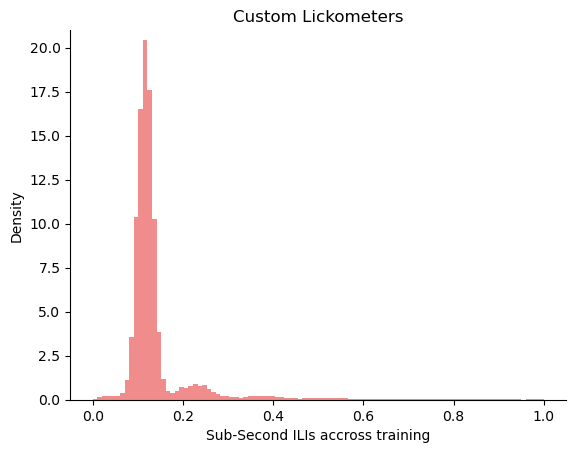

In [9]:
f = np.array([])
for i in training.raw_data:
    c = i.events['left_licks']
    c=(c[1:]-c[:-1])
    f=np.concatenate((f,c))
plt.hist(f[f<1], np.linspace(0,1, 100), alpha=.5, density = True);
plt.xlabel('Sub-Second ILIs accross training')
plt.ylabel('Density')
plt.title('Custom Lickometers')
plt.ylim(0,21)
sns.despine()

plt.savefig(os.path.join('figures', 'methods', 'pdfs', 'ili_resolutin_benchmark_custom.pdf'))
plt.savefig(os.path.join('figures', 'methods', 'svgs', 'ili_resolutin_benchmark_custom.svg'))

## Bulk analysis

In [7]:
# time lock to first lick
first_lick = time_lock_lick(training, 0)

/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/utils.py:204: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a.err_490 = tmp.groupby('cond', axis = 1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/utils.py:209: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a.err_405 = tmp2.groupby('cond', axis = 1).sem()


### plot time lock mean traces

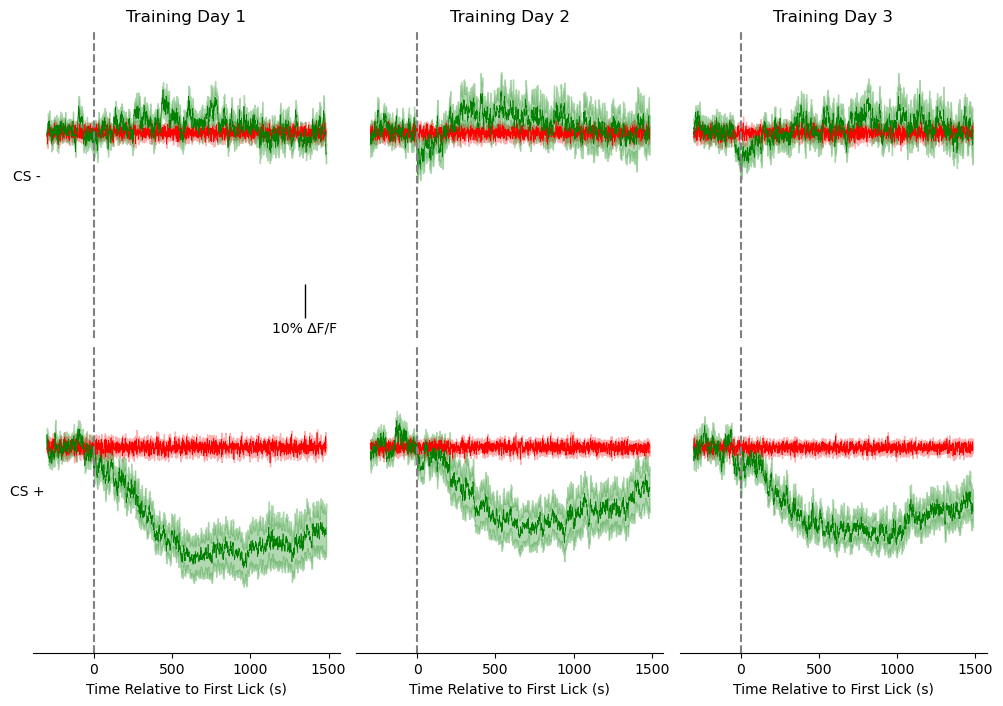

In [8]:
# let's plot both the 470 and 405 for all sessions
fig,ax = plt.subplots(2,3, figsize = (10,7))
ylim = (-.6, .3)

# plot cs- sessions
for i,v in enumerate(cs['-']):
    first_lick.plot_both(cond = v, ax=ax[0,i], 
                       show=False, scale=1, c490 = 'g')
    ax[0,i].set( xlabel = '', ylabel = '',
                 title = f'Training Day {i+1}', 
                 ylim = ylim)
    ax[0,i].axvline(0,ls='--',c='grey')
    ax[0,i].tick_params(left=False,bottom=False, 
                        labelleft=False,labelbottom=False)

    sns.despine(ax=ax[0,i], left = True, bottom = True)
    
# plot cs+ sessions
for i,v in enumerate(cs['+']):
    first_lick.plot_both(cond = v, ax=ax[1,i], 
                       show=False, scale=1, c490 = 'g')
    ax[1,i].set( xlabel = 'Time Relative to First Lick (s)',
                 ylim = ylim, ylabel = '')
    ax[1,i].axvline(0,ls='--',c='grey')
    ax[1,i].tick_params(left=False,labelleft=False)
    sns.despine(ax=ax[1,i], left = True)

ax[0,0].set_ylabel('CS -', rotation = 0)
ax[1,0].set_ylabel('CS +', rotation = 0)

# create a size bar so we can remove the axes
vertbar = AnchoredSizeBar(ax[0,0].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[0,0].add_artist(vertbar)

# format  the plot and show
fig.tight_layout(pad = .5)
plt.show()

# save the figure
fig.savefig( os.path.join(first_lick_pdfs, 'avg_training_first_lick.pdf') , transparent=True, bbox_inches='tight')
fig.savefig( os.path.join(first_lick_svgs, 'avg_training_first_lick.svg') , transparent=True, bbox_inches='tight')

### plot traces for each mouse

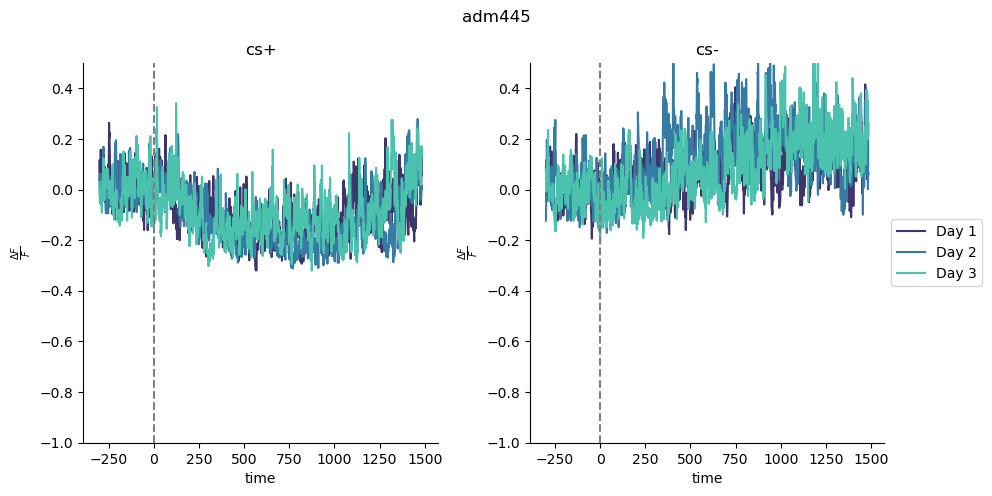

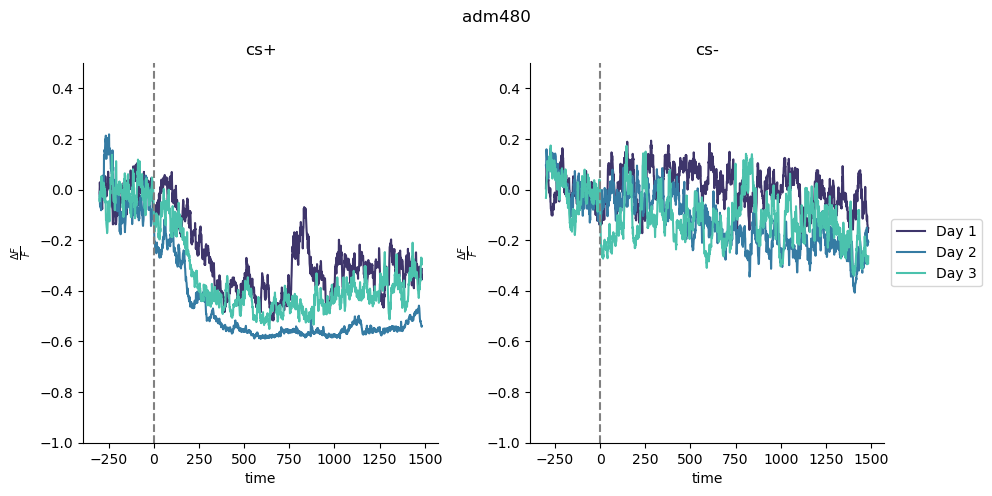

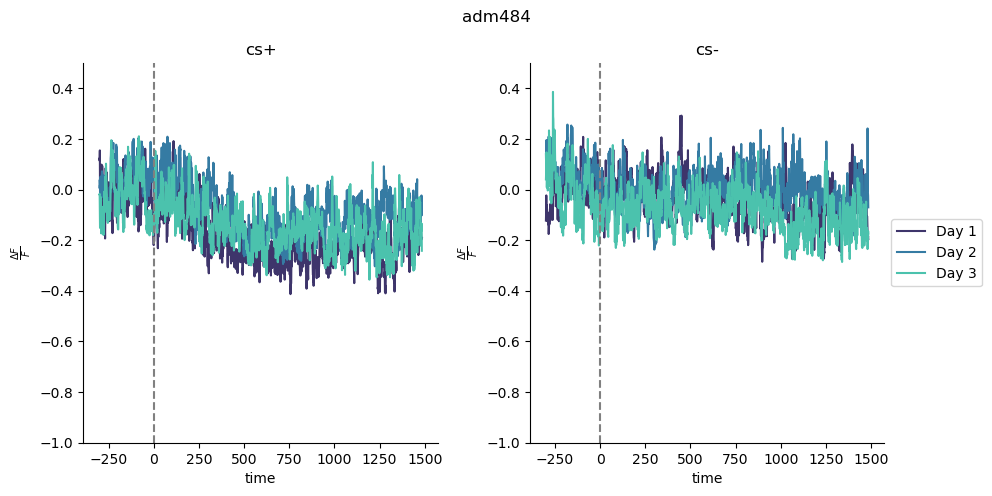

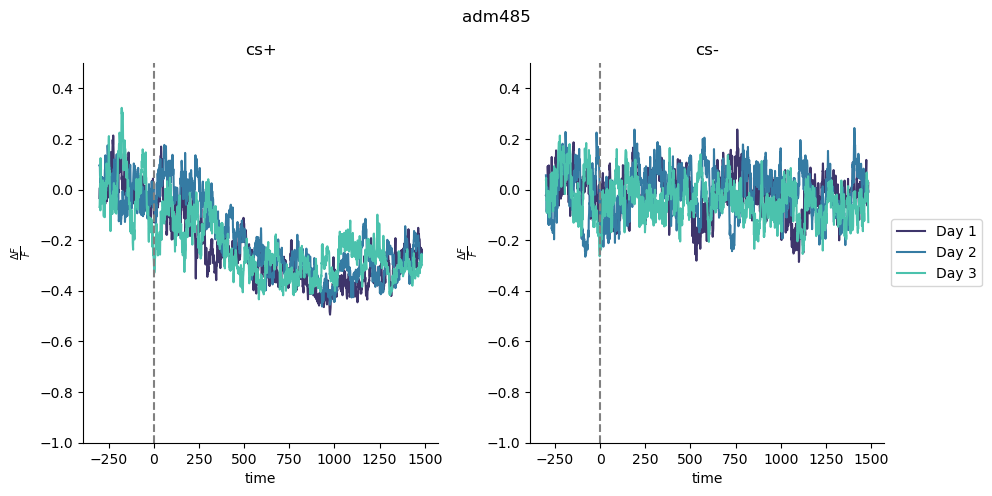

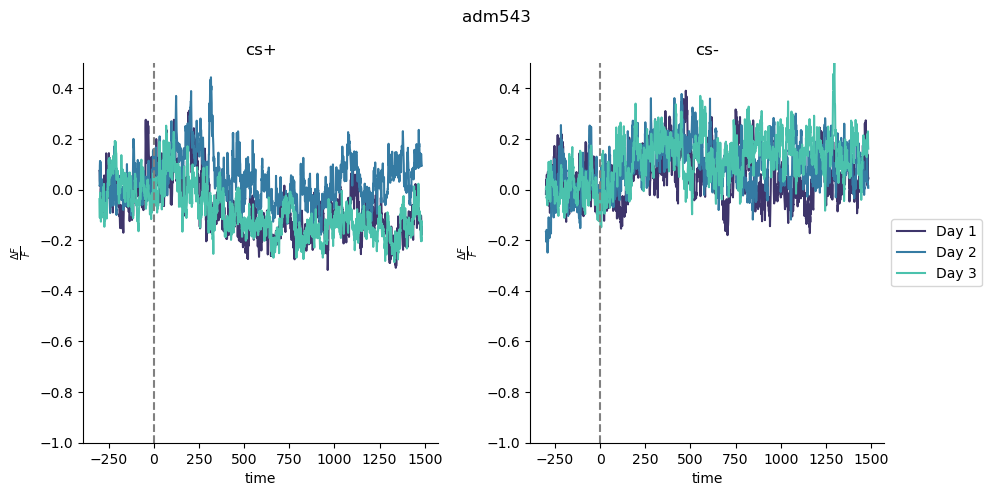

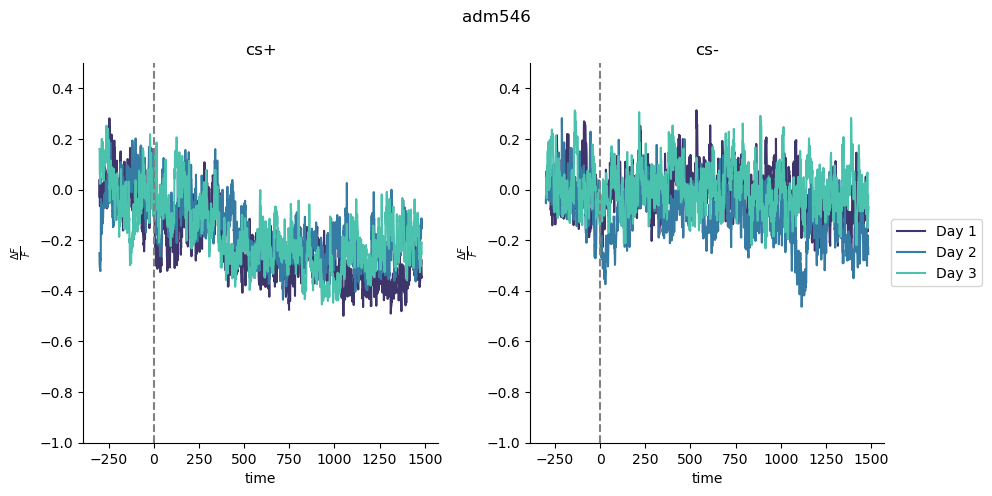

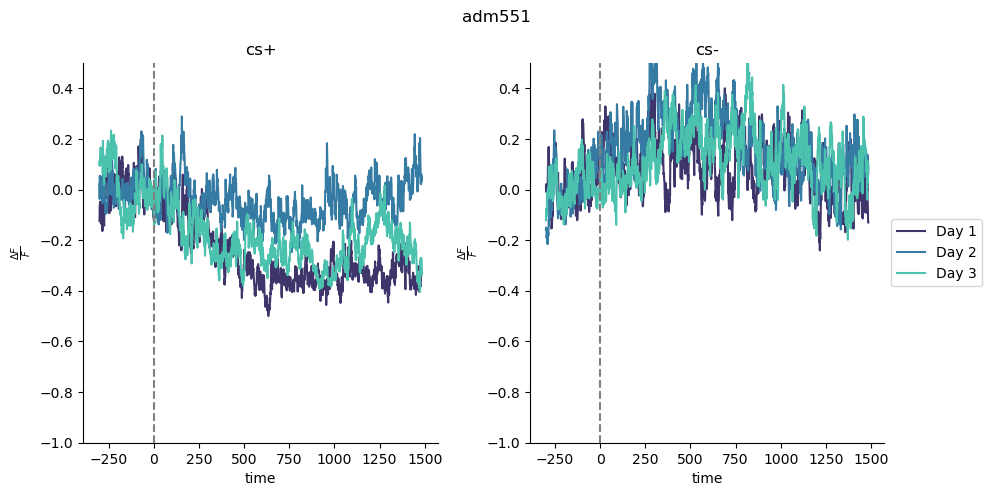

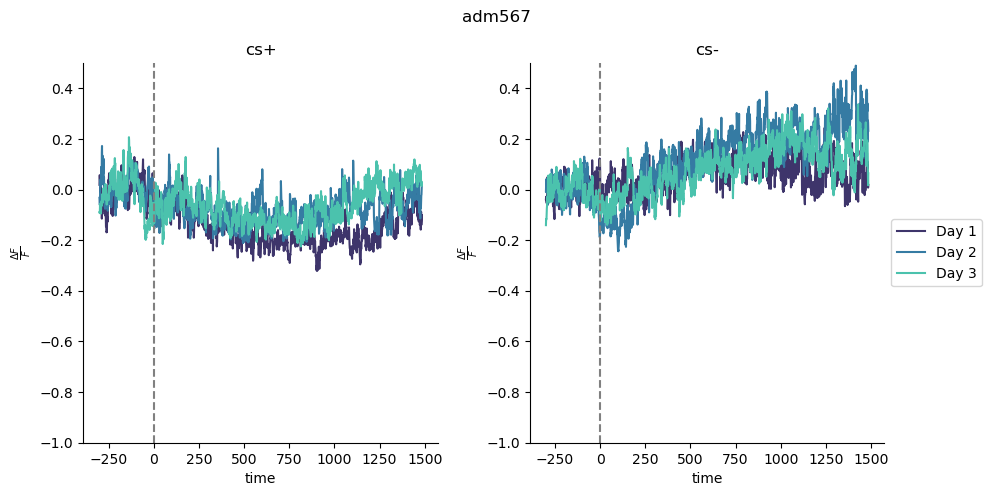

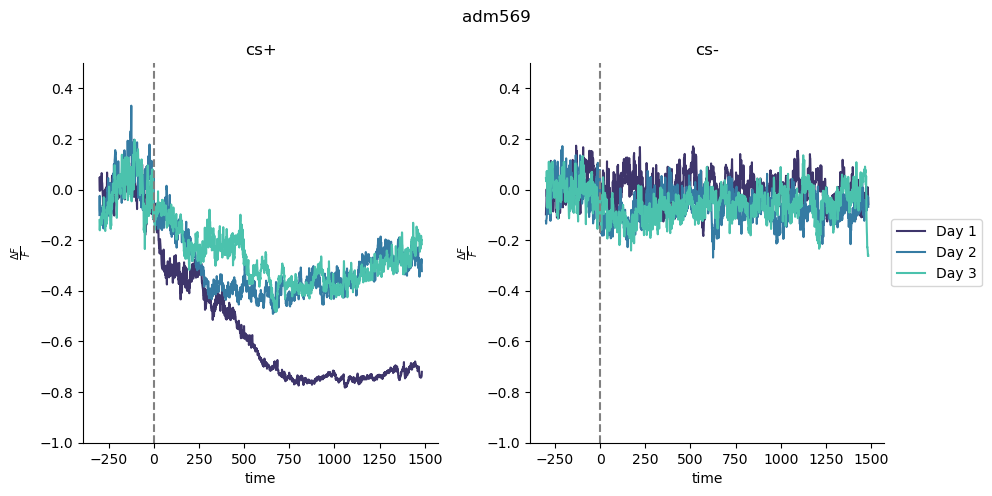

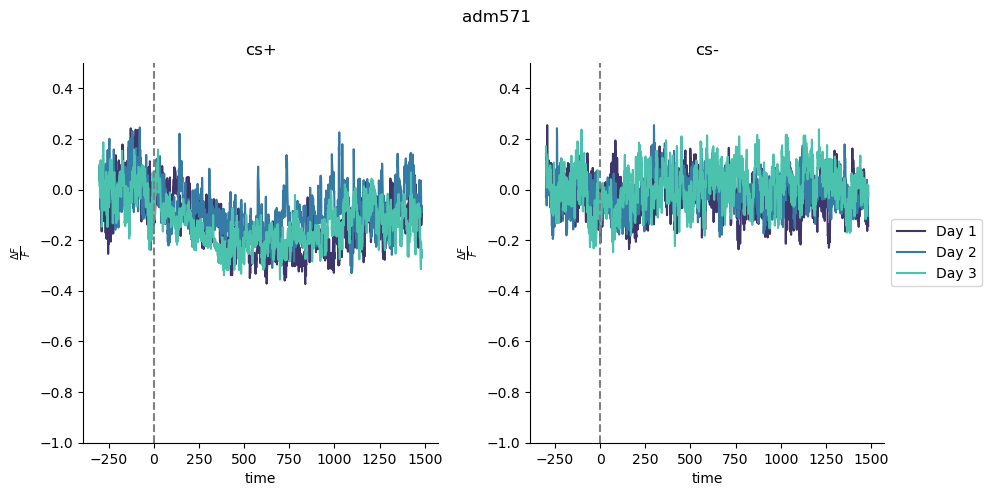

In [9]:
# # loop over the mice
for m in first_lick.mice:
    # create subplot
    fig,ax = plt.subplots(1,2, figsize = (10,5))
    
    # get mouse's cs+ licks
    tmp= first_lick.all_490.loc[:,cs['+']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                 hue='day', ax=ax[0], palette = 'mako', legend = False)
    sns.despine()
    ax[0].set_title('cs+')
    ax[0].set_ylim(-1,.5)
    ax[0].axvline(0, c='gray', ls = '--' )
    
    # get mouse's cs- licks
    tmp= first_lick.all_490.loc[:,cs['-']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    g = sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                     hue='day', ax=ax[1], palette = 'mako')
    sns.despine()
    
    # format plot
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].set_title('cs-')
    ax[1].set_ylim(-1,.5)
    ax[1].axvline(0, c='gray', ls = '--' )  
    fig.suptitle(m)
    fig.tight_layout(pad=1.)
    
    # save the figure
    pdf_path = os.path.join(first_lick_pdfs, m)
    svg_path = os.path.join(first_lick_svgs, m)
    if not os.path.exists(pdf_path): os.mkdir(pdf_path)
    if not os.path.exists(svg_path): os.mkdir(svg_path)   
    fig.savefig(os.path.join(pdf_path, f'{m}_full_trace_training.pdf'))
    fig.savefig(os.path.join(svg_path, f'{m}_full_trace_training.svg'))



---

### summary plot

In [10]:
# get total licks and means for each mouse for each training day
# get all the lick data
means = first_lick.bin_avg(0, first_lick.t_endrec, pr = False)
mins = first_lick.mean_peak_df_f('min', pr = False, trap = True)
tmp =  []

for i in first_lick.normed_data:
    tmp.append({'mouse'      : i.mouse_id,
                'total_licks': i.events['left_licks'].size,
                'meandf'     : means.loc[pd.IndexSlice[i.cond,i.mouse_id],'Mean ∆F/F'], 
                'mindf'      : mins.loc[pd.IndexSlice[i.cond,i.mouse_id],'min ∆F/F'],
                'min_loc'    : mins.loc[pd.IndexSlice[i.cond,i.mouse_id],'ts'],
                'CS'         : '+' if i.cond in cs['+'] else '-',
                'day'        : int(i.cond.split('_')[1])
               })
train_stats = pd.DataFrame(tmp)
mn_train_stats = train_stats.groupby(['mouse','CS']).mean().unstack('CS')

Warning! min is on the edge of the recording


#### make the plot

/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeri

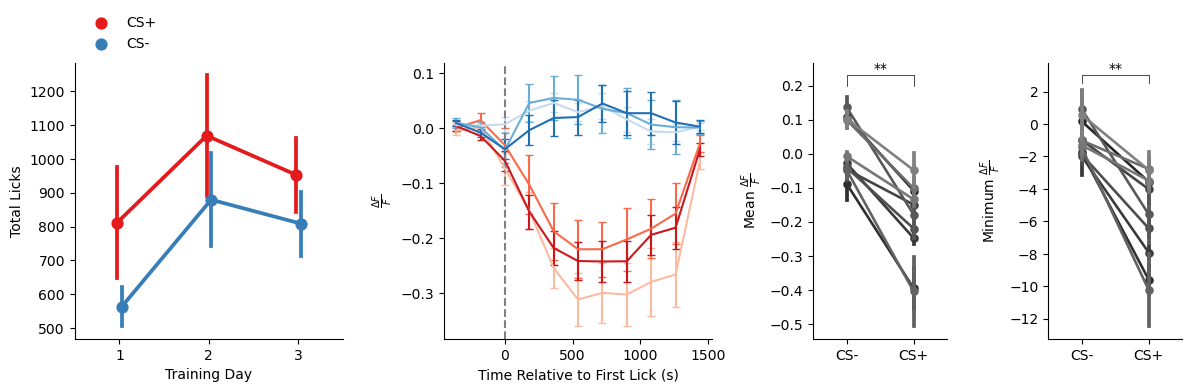

In [11]:
# create subplot
fig, ax = plt.subplots(1,4, figsize = (12,4), gridspec_kw={'width_ratios': [1, 1, .5, .5]})

# plot the total licks over the course of training
ax[0].set_prop_cycle(color = sns.color_palette('Set1'))
sns.pointplot(data = train_stats, x = 'day', y = 'total_licks', hue = 'CS', 
              errorbar = 'se', dodge = True, hue_order = ['+','-'], ax = ax[0])
ax[0].set(xlabel='Training Day', xticks = [0,1,2], xticklabels = [1,2,3], ylabel='Total Licks')
ax[0].legend(ax[0].get_legend_handles_labels()[0], ['CS+', 'CS-'], bbox_to_anchor=(0,1), loc='lower left', frameon=False)

# plot the binned data for all sessions and color code by CS
# cs + 
for i,j in zip(cs['+'], sns.color_palette('Reds', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[1], color =j ,show=False, scale=1);

# cs-
for i,j in zip(cs['-'], sns.color_palette('Blues', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[1], color =j ,show=False,scale=1);
ax[1].axvline(0,ls='--',c='grey')
ax[1].set(xlabel = 'Time Relative to First Lick (s)',
          ylabel = r'$\frac{\Delta F}{F}$')
ax[1].get_legend().remove()



# plot average mean df/f for CS+ and CS- trials for each mouse
sns.pointplot(data = train_stats, x='CS', y='meandf', hue='mouse',
              errorbar='se', order=['-','+'], color='gray',
              ax=ax[2], scale=.7)
ax[2].get_legend().remove()


# plot stats
mean_stat = pd.Series(st.wilcoxon(mn_train_stats['meandf']['+'], 
                                  mn_train_stats['meandf']['-']), 
                      index=('W', 'p-value'))
plot_significance(mean_stat.loc['p-value'], ax[2], 0,1,0.2,.03)
ax[2].set(xlim = (-.5,1.5), xticks = (0,1),
          xticklabels = ['CS-', 'CS+'],
          ylabel = r'Mean $\frac{\Delta F}{F}$', xlabel = '');


# plot average minimum df/f for CS+ and CS- trials for each mouse
sns.pointplot(data = train_stats, x='CS', y='mindf', hue='mouse',
              errorbar='se', order=['-','+'], color='gray',
              ax=ax[3], scale=.7)
ax[3].get_legend().remove()

# plot stats
min_stat = pd.Series(st.wilcoxon(mn_train_stats['mindf']['+'], 
                                 mn_train_stats['mindf']['-']), 
                     index=('W', 'p-value'))
plot_significance(min_stat.loc['p-value'], ax[3], 0,1,2.5,.5)
ax[3].set(xlim = (-.5,1.5), xticks = (0,1), 
          xticklabels = ['CS-', 'CS+'],
          ylabel = r'Minimum $\frac{\Delta F}{F}$', xlabel = '');

# format the plot
sns.despine()
fig.tight_layout(pad = 1.)

# save the figure
fig.savefig(os.path.join(first_lick_pdfs, 'training_summary.pdf'))
fig.savefig(os.path.join(first_lick_svgs, 'training_summary.svg'))

#### stats

##### stats - training licks

F Value  Num DF  Den DF    Pr > F Significance
day     4.636146     2.0    18.0  0.023766            *
CS      7.306893     1.0     9.0  0.024269            *
day:CS  0.198023     2.0    18.0  0.822114           ns

t   p-value   df  Corrected p-value Significance
Comparison                                                             
Day 1 vs Day 2 -2.434764  0.037687  9.0           0.073954           ns
Day 1 vs Day 3 -2.434764  0.037687  9.0           0.073954           ns

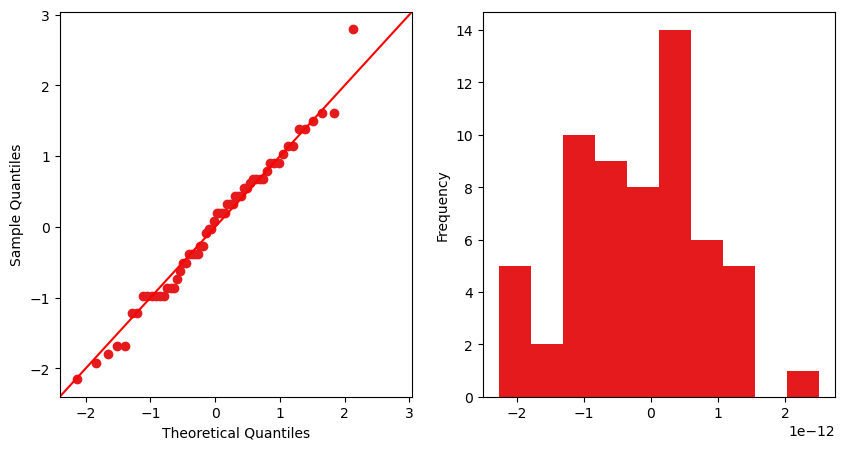

In [14]:
lick_anova = AnovaRM(train_stats, 'total_licks', 'mouse', within = ['day','CS']).fit().summary().tables[0]
lick_anova['Significance'] = lick_anova['Pr > F'].apply(check_significance)

r = smf.ols('total_licks ~ C(day,Sum)*C(CS,Sum)*C(mouse,Sum)', data = train_stats).fit().resid

_, ax = plt.subplots(1,2, figsize = (10,5))
sm.qqplot(r, fit=True, line='45', ax = ax[0])
r.plot.hist(ax=ax[1])

mn_train_licks = train_stats.groupby(['mouse','day']).total_licks.mean().unstack('day')
t = st.ttest_rel(mn_train_licks[1], mn_train_licks[2])
d1v2 = pd.Series(list(t) + [t.df], index=('t', 'p-value', 'df'))
t = st.ttest_rel(mn_train_licks[1], mn_train_licks[2])
d1v3 = pd.Series(list(t) + [t.df], index=('t', 'p-value', 'df'))
lick_stats = pd.concat({'Day 1 vs Day 2': d1v2, 'Day 1 vs Day 3': d1v3}).unstack()
lick_stats['Corrected p-value'] = multipletests(lick_stats['p-value'], method='holm-sidak')[1]
lick_stats.index.name = "Comparison"
lick_stats['Significance'] = lick_stats['Corrected p-value'].apply(check_significance)

display(lick_anova, lick_stats)

main_train_fig_stats.update({'c_train_licks_anova': lick_anova,
                             'c_train_licks_stats': lick_stats})

##### stats - full traces

/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],


F Value  Num DF  Den DF        Pr > F Significance
day           1.827801     2.0    18.0  1.893739e-01           ns
cs           66.646489     1.0     9.0  1.882017e-05         ****
time          8.695016    10.0    90.0  8.303757e-10         ****
day:cs        2.363124     2.0    18.0  1.226600e-01           ns
day:time      2.470343    20.0   180.0  8.653748e-04          ***
cs:time      54.547474    10.0    90.0  7.388032e-34         ****
day:cs:time   0.950898    20.0   180.0  5.240053e-01           ns

t   p-value   df  Corrected p-value  \
Comparison     Time                                                  
Day 1 vs Day 2 -360.0  -0.570110  0.582553  9.0           0.987323   
               -180.0  -0.542668  0.600537  9.0           0.987323   
                0.0     0.116578  0.909754  9.0           0.991604   
                180.0  -1.380017  0.200893  9.0           0.960394   
                360.0  -1.375642  0.202198  9.0           0.960394   
                540.0  -1.754515  0.113236  9.0           0.935443   
                720.0  -1.051409  0.320481  9.0           0.960394   
                900.0  -1.558157  0.153624  9.0           0.960394   
                1080.0 -1.577739  0.149081  9.0           0.960394   
                1260.0 -1.558031  0.153654  9.0           0.960394   
                1440.0 -1.558890  0.153452  9.0           0.960394   
Day 1 vs Day 3 -360.0  -1.387104  0.198797  9.0           0.960394   
               -180.0   3.589127  0.005847  9.0           0.136359   
                0.0     0.933946  0.374710  9.0           0.960394   
                180.0   1.153900  0.278262  9.0           0.960394   
                360.0  -0.244346  0.812442  9.0           0.991604   
                540.0  -1.382696  0.200099  9.0           0.960394   
                720.0  -1.319229  0.219668  9.0           0.960394   
                900.0  -1.448164  0.181496  9.0           0.960394   
                1080.0 -2.622541  0.027695  9.0           0.490367   
                1260.0 -1.759695  0.112316  9.0           0.935443   
                1440.0 -1.240012  0.246326  9.0           0.960394   
CS+ vs CS-     -360.0  -1.559592  0.153287  9.0           0.960394   
               -180.0   0.265305  0.796751  9.0           0.991604   
                0.0    -1.711186  0.121208  9.0           0.935443   
                180.0  -5.204334  0.000561  9.0           0.014479   
                360.0  -8.546817  0.000013  9.0           0.000403   
                540.0  -9.251418  0.000007  9.0           0.000218   
                720.0  -9.514384  0.000005  9.0           0.000178   
                900.0  -7.976307  0.000023  9.0           0.000680   
                1080.0 -7.719335  0.000029  9.0           0.000853   
                1260.0 -7.595516  0.000033  9.0           0.000935   
                1440.0 -6.346637  0.000133  9.0           0.003596   

                       Significance  
Comparison     Time                  
Day 1 vs Day 2 -360.0            ns  
               -180.0            ns  
                0.0              ns  
                180.0            ns  
                360.0            ns  
                540.0            ns  
                720.0            ns  
                900.0            ns  
                1080.0           ns  
                1260.0           ns  
                1440.0           ns  
Day 1 vs Day 3 -360.0            ns  
               -180.0            ns  
                0.0              ns  
                180.0            ns  
                360.0            ns  
                540.0            ns  
                720.0            ns  
                900.0            ns  
                1080.0           ns  
                1260.0           ns  
                1440.0           ns  
CS+ vs CS-     -360.0            ns  
               -180.0            ns  
                0.0              ns  
                180.0             *  
                360.0           ***  
                540.0           ***  
                720.0           ***  
                900.0           ***  
                1080.0          ***  
                1260.0          ***  
                1440.0           **

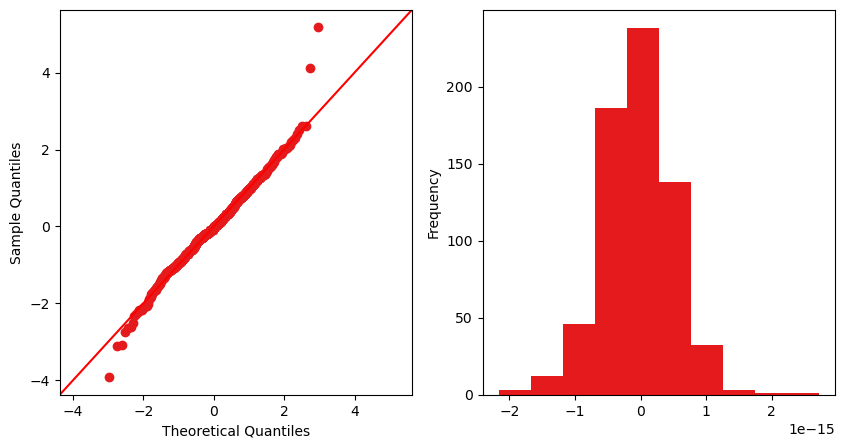

In [16]:
binned = first_lick.bin_data(180, save=False)[1].T.stack()
binned.name = 'df'
binned = reindex(binned)
binned.columns.name = ''
binned = binned.reset_index()
binned = binned.rename(columns = {'bin start (s)': 'time'})

anova_train_trace = AnovaRM(binned, 'df', 'mouse', within = ['day','cs', 'time']).fit().summary().tables[0]
anova_train_trace['Significance'] = anova_train_trace['Pr > F'].apply(check_significance)


r = smf.ols('df ~ C(day,Sum)*C(cs,Sum)*C(time,Sum)*C(mouse,Sum)', data = binned).fit().resid
_, ax = plt.subplots(1,2, figsize = (10,5))
sm.qqplot(r, fit=True, line='45', ax = ax[0])
r.plot.hist(ax=ax[1])

bd =   binned.groupby(['day', 'mouse', 'time']).df.mean().unstack('day')
d1v2 = bd.groupby('time').apply(lambda x: st.ttest_rel(x[1], x[2])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value','df')))
d1v3 = bd.groupby('time').apply(lambda x: st.ttest_rel(x[1], x[3])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value','df')))
bd =   binned.groupby(['cs', 'mouse', 'time']).df.mean().unstack('cs')
pvm =  bd.groupby('time').apply(lambda x: st.ttest_rel(x['+'], x['-'])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t','p-value','df')))

stats_train_trace = pd.concat({'Day 1 vs Day 2': d1v2, 
                               'Day 1 vs Day 3': d1v3, 
                               'CS+ vs CS-': pvm})

stats_train_trace['Corrected p-value'] = multipletests(stats_train_trace['p-value'], method='holm-sidak')[1]
stats_train_trace.index = stats_train_trace.index.set_names(["Comparison", "Time"])
stats_train_trace['Significance'] = stats_train_trace['Corrected p-value'].apply(check_significance)

display(anova_train_trace, stats_train_trace)

main_train_fig_stats.update({'d_train_trace_anova': anova_train_trace,
                             'd_train_trace_stats': stats_train_trace})

##### stats - average mean ∆F/F comparison

In [17]:
mean_stat = mean_stat.rename("CS+ vs CS-").to_frame().T
mean_stat['Significance'] = check_significance(mean_stat['p-value'].values[0])
display(mean_stat)
main_train_fig_stats.update({"e_mean_stat": mean_stat})

W   p-value Significance
CS+ vs CS-  0.0  0.001953           **

##### stats - average min ∆F/F comparison

In [18]:
min_stat = min_stat.rename("CS+ vs CS-").to_frame().T
min_stat['Significance'] = check_significance(min_stat['p-value'].values[0])
display(min_stat)
main_train_fig_stats.update({"f_min_stat": min_stat})

W   p-value Significance
CS+ vs CS-  0.0  0.001953           **

### (supplement) each day quantification

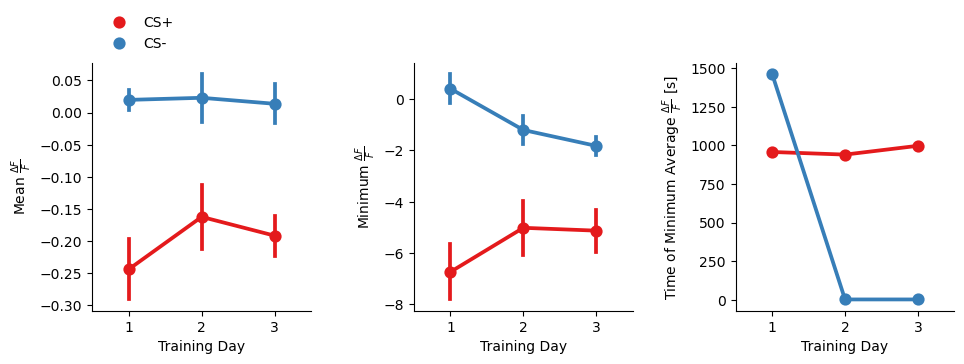

In [62]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
sns.pointplot(train_stats, x='day', y='meandf', hue='CS', 
              errorbar = 'se', ax = ax[0], hue_order = ['+','-'])
sns.pointplot(train_stats, x='day', y='mindf', hue='CS', 
              errorbar = 'se', ax = ax[1], hue_order = ['+','-'])
sns.pointplot(train_stats, x='day', y='min_loc', hue='CS',
              errorbar = None, ax = ax[2], hue_order = ['+','-'])

ax[0].set_ylabel(r"Mean $\frac{\Delta F}{F}$")
ax[0].legend(ax[0].get_legend_handles_labels()[0], ['CS+', 'CS-'], 
             bbox_to_anchor=(0,1), loc='lower left', frameon=False)
ax[0].set_xlabel(r"Training Day")

ax[1].set_ylabel(r"Minimum $\frac{\Delta F}{F}$")
ax[1].get_legend().remove()
ax[1].set_xlabel(r"Training Day")

ax[2].set_ylabel(r"Time of Minimum Average $\frac{\Delta F}{F}$ [s]")
ax[2].get_legend().remove()
ax[2].set_xlabel(r"Training Day")


fig.tight_layout(pad = 2.)
sns.despine()

fig.savefig(os.path.join(first_lick_pdfs, 'training_summary_supp.pdf'))
fig.savefig(os.path.join(first_lick_svgs, 'training_summary_supp.svg'))

#### stats

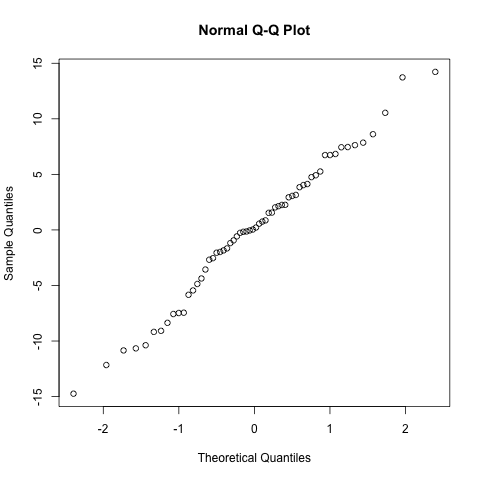

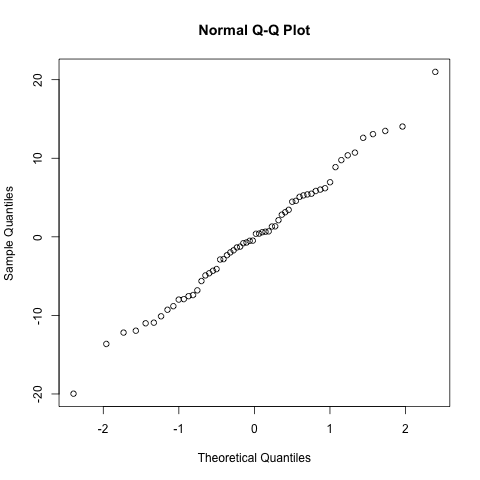

In [63]:
%%R -i train_stats -o mean_anova_ranks -o min_anova_ranks
m <- lmer("rank(meandf) ~ factor(day)*factor(CS) + (1|mouse)", train_stats)
qqnorm(residuals(m))
mean_anova_ranks <- anova(m)

m <- lmer("rank(mindf) ~ factor(day)*factor(CS) + (1|mouse)", train_stats)
qqnorm(residuals(m))
min_anova_ranks <- anova(m)

In [64]:
mean_anova_ranks['Significance'] = mean_anova_ranks['Pr(>F)'].apply(check_significance)
min_anova_ranks['Significance'] = min_anova_ranks['Pr(>F)'].apply(check_significance)


df = train_stats.set_index(['day','CS','mouse']).mindf

pvm = df.unstack('CS').groupby('day').apply(lambda x: pd.Series(st.wilcoxon(x['+'], x['-']), index=('W', 'p-value')))
d1v2 = df.unstack('day').groupby('CS').apply(lambda x: pd.Series(st.wilcoxon(x[1], x[2]), index=('W', 'p-value')))
d1v3 = df.unstack('day').groupby('CS').apply(lambda x: pd.Series(st.wilcoxon(x[1], x[3]), index=('W', 'p-value')))

min_stat_perd = pd.concat({'Day 1 vs Day 2': d1v2.reset_index(), 
                           'Day 1 vs Day 3': d1v3.reset_index(), 
                           'CS+ vs CS-': pvm.reset_index()}).droplevel(1)

min_stat_perd.index.name = 'Comparison'
min_stat_perd = min_stat_perd.reset_index()
min_stat_perd['Corrected p-value'] = multipletests(min_stat_perd['p-value'], method='holm-sidak')[1]
min_stat_perd['Significance'] = min_stat_perd['Corrected p-value'].apply(check_significance)


display(mean_anova_ranks, min_anova_ranks, min_stat_perd)


supp_train_fig_bulk_stats = {"a_mean_anova_ranks": mean_anova_ranks,
                             "b_min_anova_ranks" : min_anova_ranks,
                             "b_min_posthoc" : min_stat_perd}

Sum Sq      Mean Sq  NumDF  DenDF     F value  \
factor(day)               174.70000     87.35000      2   45.0    1.684126   
factor(CS)              10454.40042  10454.40042      1   45.0  201.562991   
factor(day):factor(CS)    291.90000    145.95000      2   45.0    2.813946   

                              Pr(>F) Significance  
factor(day)             1.970937e-01           ns  
factor(CS)              3.115615e-18         ****  
factor(day):factor(CS)  7.055212e-02           ns

Sum Sq       Mean Sq  NumDF  DenDF     F value  \
factor(day)               161.200000     80.600000      2   45.0    1.032373   
factor(CS)              10454.401061  10454.401061      1   45.0  133.906160   
factor(day):factor(CS)   1346.800000    673.400000      2   45.0    8.625306   

                              Pr(>F) Significance  
factor(day)             3.644417e-01           ns  
factor(CS)              4.425802e-15         ****  
factor(day):factor(CS)  6.746057e-04          ***

Comparison   CS     W   p-value  day  Corrected p-value Significance
0  Day 1 vs Day 2    +  11.0  0.105469  NaN           0.124752           ns
1  Day 1 vs Day 2    -   9.0  0.064453  NaN           0.124752           ns
2  Day 1 vs Day 3    +   5.0  0.019531  NaN           0.057457           ns
3  Day 1 vs Day 3    -   2.0  0.005859  NaN           0.023232            *
4      CS+ vs CS-  NaN   0.0  0.001953  1.0           0.013592            *
5      CS+ vs CS-  NaN   1.0  0.003906  2.0           0.019379            *
6      CS+ vs CS-  NaN   0.0  0.001953  3.0           0.013592            *

In [65]:
with pd.ExcelWriter('stats/raw/supp_train_full_trace_stats.xlsx') as writer:  
    for k,v in supp_train_fig_bulk_stats.items():
        v.to_excel(writer, sheet_name=k)

## bout level analyses

Here we're interested in whether or not we can identify faster dynamics time-locked to the initiation of lick bouts. First we need to identify the onsets of lick bouts.

In [6]:
# load training data
training = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(Path('data/cohort1/training.npy'))
training.load_append_save(Path('data/cohort2/training.npy'))
training.compute()

loading data from file...
loading data from file...
recomputing...
successful


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


In [7]:
# compute lick bout times for training
for i,v in training.raw_data.items():
    l = training.raw_data.loc[i].events['left_licks'] 
    ili = np.append(bout_thresh + 1, l[1:] - l[:-1])
    training.raw_data.loc[i].events['left_bouts'] = l[ili > bout_thresh]

# compute lick rates during training
lr_train = get_lick_rate(training, 'left_licks', sigma = .4, win = 2)
peri_bout_lr = peri_event(training, 'left_bouts', peri_window, df = lr_train)
peri_bout_lr = reindex(peri_bout_lr) 

In [8]:
orig_training = deepcopy(training) # keep a version before detrending

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = training.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate the baseline with a moving average
bl = training.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
training.t_prestim = -new_t[0]
training.t_endrec = new_t[-1]
training.all_490 = training.all_490.loc[bl.index]

# normalize relative to the baseline
training.all_490 = (training.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
training.all_490 = (training.all_490 - training.all_490.loc[:0].mean(axis=0))/training.all_490.loc[:0].std(axis=0)

In [9]:
# check how many bouts we are removing due to
max_rm_bouts = training.raw_data.map(lambda x: (x.events['left_bouts']>training.t_endrec).sum()).max()
mn_rm_bouts = training.raw_data.map(lambda x: (x.events['left_bouts']>training.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmean number bouts removed:', mn_rm_bouts)

max removed bouts: 1 
mean number bouts removed: 0.25


### (supplemental) - demo of detrending method

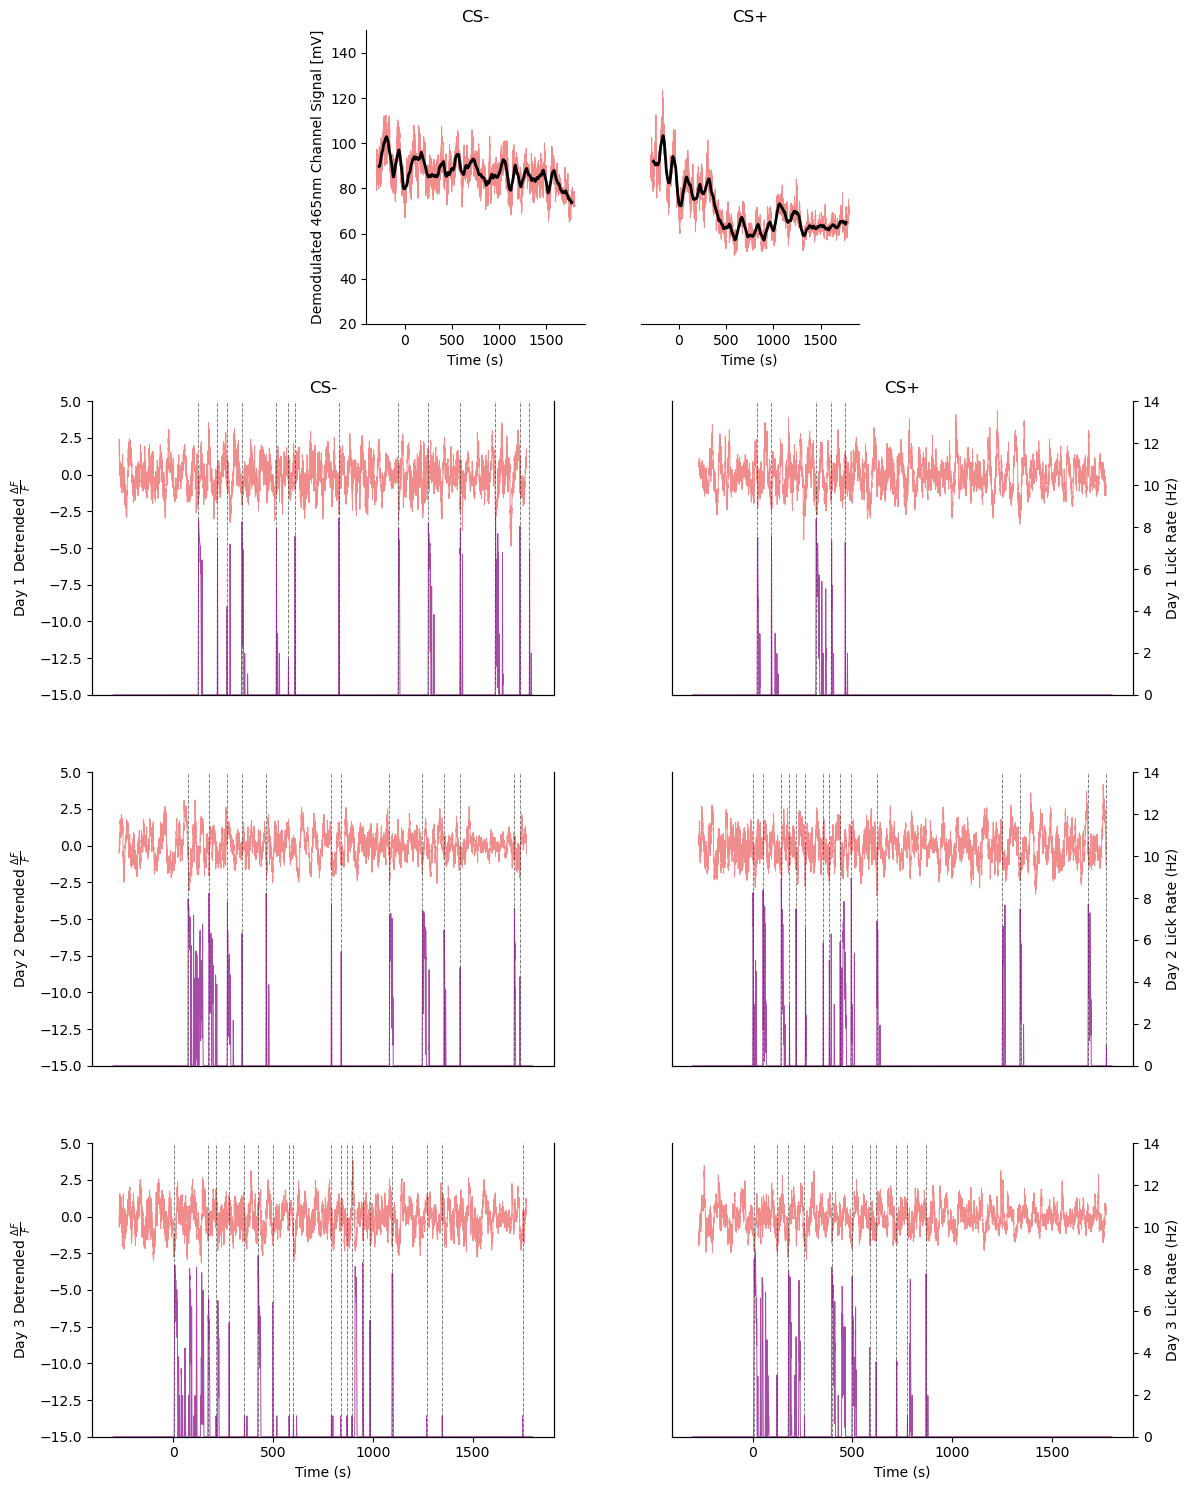

In [24]:
# create the plot
fig = plt.figure(figsize = (12,15))

# plot example model fit for a CS- session
m = 'adm485' # example mouse
ylim = (20, 150)
ax = fig.add_subplot(442)
ax.plot(orig_training.all_490['training_3_am', m], alpha = .5, lw = .7)
ax.plot( bl['training_3_am', m], c = 'k', lw = 2)
ax.set_ylabel(r'Demodulated 465nm Channel Signal [mV]')
ax.set_xlabel('Time (s)')
ax.set_title("CS-")
ax.set_ylim(ylim)
sns.despine()

# plot example model fit for CS+ session
ax = fig.add_subplot(443)
ax.plot(orig_training.all_490['training_3_pm',m], alpha = .5, lw = .7)
ax.plot(bl['training_3_pm', m], c = 'k', lw = 2)
ax.set_yticks([])
ax.set_xlabel('Time (s)')
ax.set_ylim(ylim)
ax.set_title("CS+")
sns.despine(ax = ax, left = True)
fig.tight_layout(pad = 1.)


# plot detrended CS+ data on top of lick rate
# day 1
# CS-
ylim  = (-15,5)
lylim = (0,14)
ax = fig.add_subplot(423)
ax.plot(training.all_490['training_1_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_am',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_1_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_title("CS-")
ax.set_ylabel(r"Day 1 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(424)
ax.plot(training.all_490['training_1_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_pm',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_1_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("CS+")
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 1 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 2
# CS-
ax = fig.add_subplot(425)
ax.plot(training.all_490['training_2_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_pm',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_2_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_ylabel(r"Day 2 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(426)
ax.plot(training.all_490['training_2_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_am',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_2_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 2 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 3
# CS-
ax = fig.add_subplot(427)
ax.plot(training.all_490['training_3_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_am',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_3_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Day 3 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(428)
ax.plot(training.all_490['training_3_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_pm',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_3_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 3 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


# format plot
fig.tight_layout(h_pad = 1, w_pad = .001)

# save the figure
fig.savefig(os.path.join('figures', 'methods', 'pdfs', 'supplement_detrending.pdf'))
fig.savefig(os.path.join('figures', 'methods', 'svgs', 'supplement_detrending.svg'))

### extracting peri-lick bout activity within different time ranges of the data

In [10]:
# get peri-bout activity for all bouts
bn= training.raw_data.apply(lambda x: get_bn(x, 'left_licks', 'left_bouts'))
for i in training.raw_data.index:
    # only include bouts with more than one lick
    training.raw_data[i].events['valid_bouts'] = training.raw_data[i].events['left_bouts'][bn.loc[i].dropna().values>1]
bn = reindex(bn.droplevel('trial').T)
bn.columns.name = 'event'
peri_bout = peri_event(training, 'valid_bouts', peri_window, norm = peri_bout_norm_train)
peri_bout = reindex(peri_bout)
mn_peri_bout = peri_bout.groupby(['day','cs','mouse']).mean()

### randomize

In [47]:
# simmulate random lick bouts and get corresponding peri bout activity
np.random.seed(32)
ctl = []

with tqdm(total = niters_rand) as pbar:
    def randomize_bouts(pid):
        global ctl_mn
        global training
        
        end_lim = training.all_490.index[-1]-peri_window-1
        for i,v in training.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['valid_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))

            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            
            #save randomized bouts
            training.raw_data.loc[i].events[f'rand_bouts_{pid}'] = np.sort(rand_evs) 
            
        # get peri-bout data for random bouts and compute the mean response
        _d = peri_event(training, f'rand_bouts_{pid}', peri_window,norm = peri_bout_norm_test)
        _d = _d.groupby(['cond','mouse'], axis=1).mean()
        ctl.append(_d)

    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)

ctl = reindex(pd.concat(dict(zip(range(len(ctl)), ctl)), 
                        axis=1, names = ['event']))
ctl_mn = ctl.groupby(['day','cs','mouse']).mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


### plot average peri-bout activity for each session

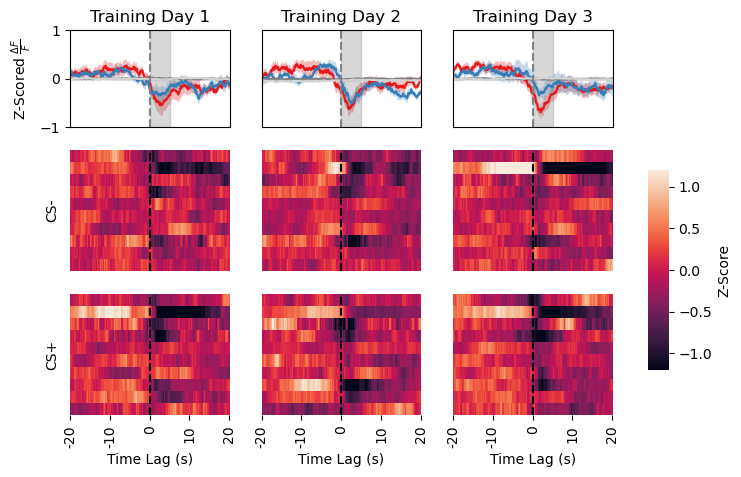

In [48]:
fig, ax = plot_peri(mn_peri_bout, ctl_mn, 'Training', save = False, vmin = -1.2, vmax=1.2);
for i in range(3):
    ax[0,i].fill_between([0,5],-1, 1, color='gray', alpha=.3)
fig.savefig(os.path.join(peri_stim_pdfs_train , 'training_all.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_train , 'training_all.svg'), bbox_inches = 'tight')

#### individual mice

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_25617/3696032791.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad = 1.)


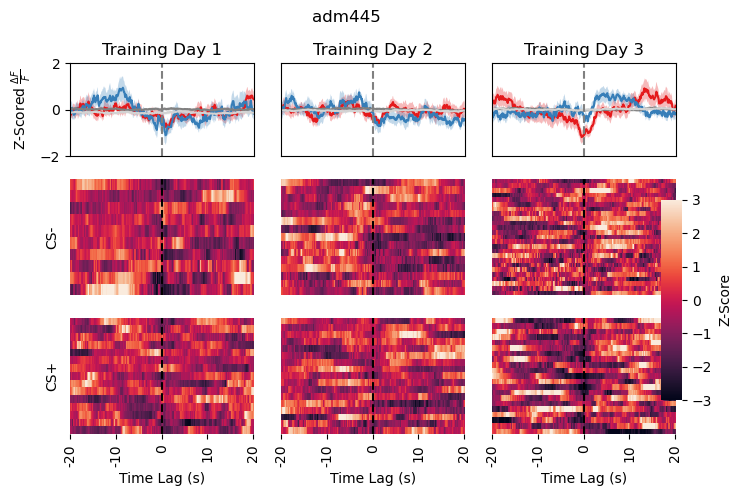

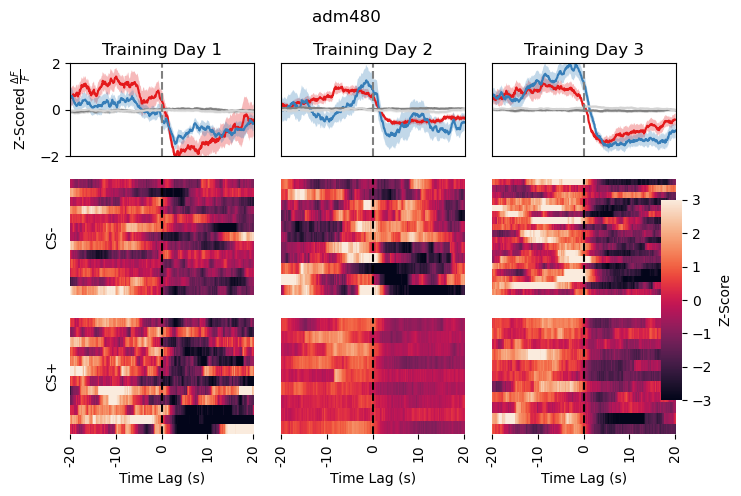

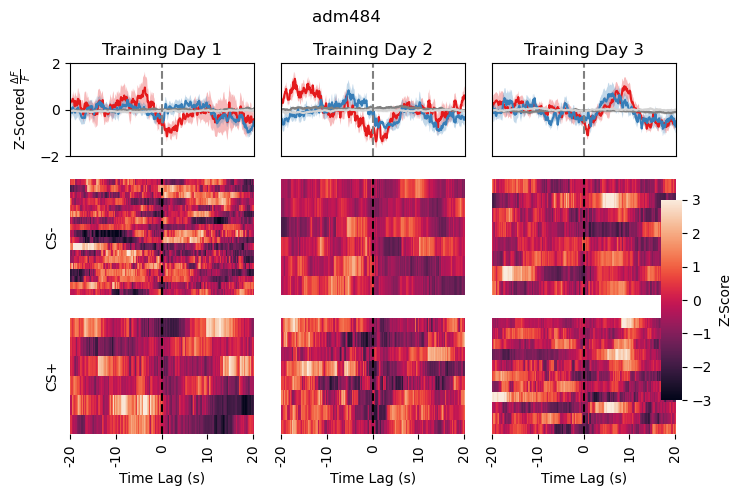

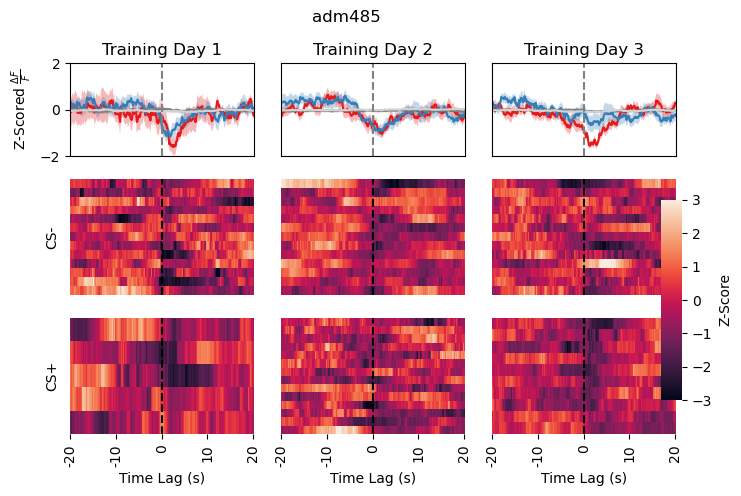

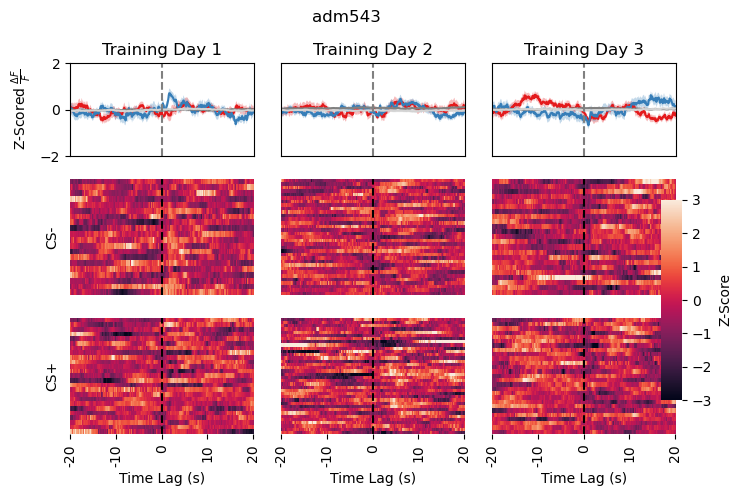

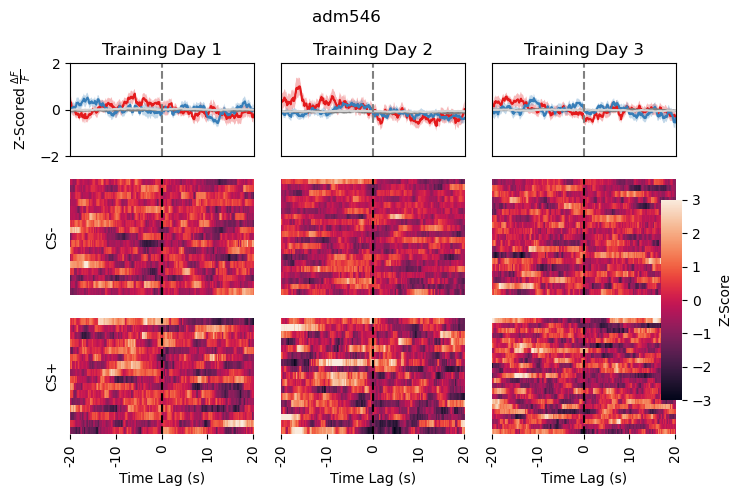

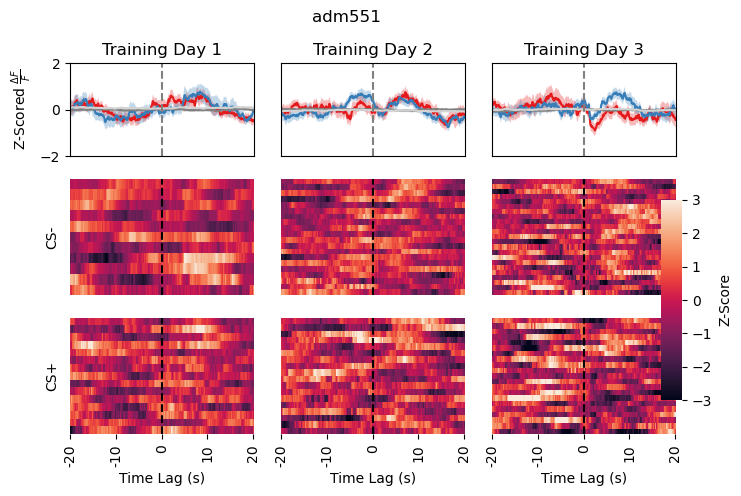

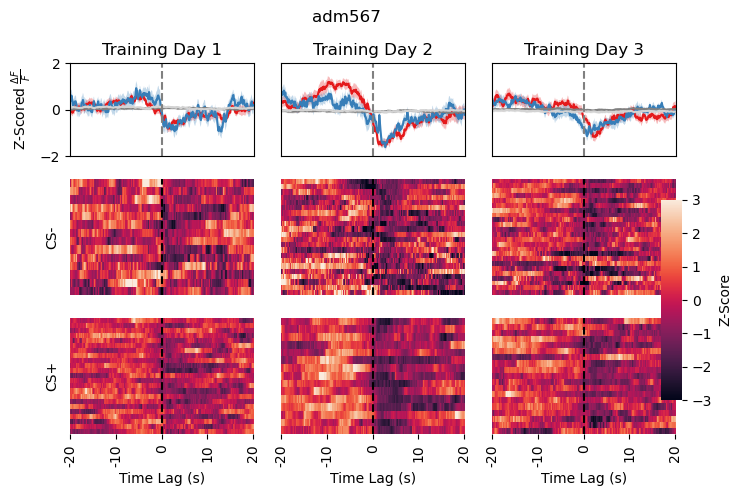

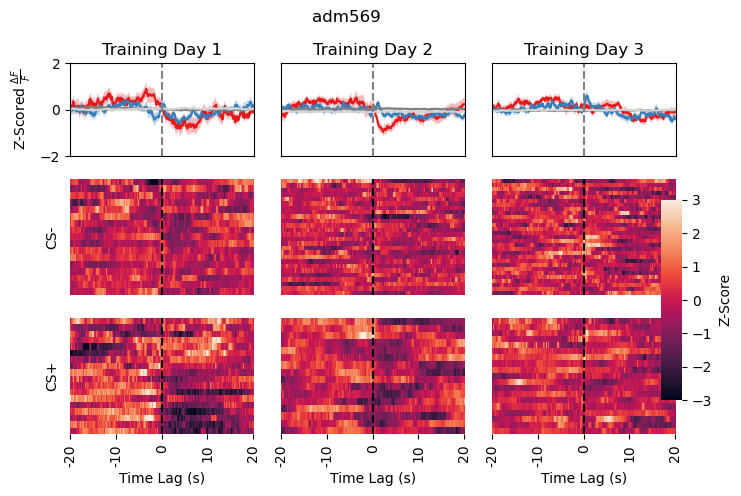

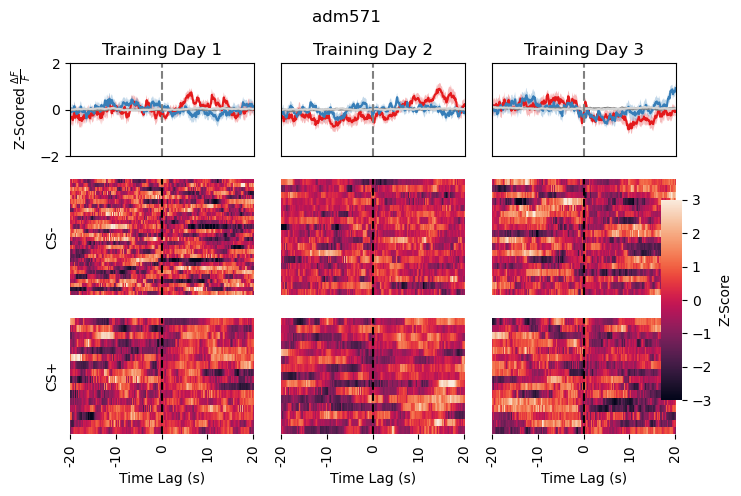

In [140]:
for i in mn_peri_bout.index.get_level_values('mouse').unique():
    fig, _ = plot_peri(peri_bout.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                          ctl = ctl.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                          save=False, vmin = -3, vmax=3, ylim = (-2,2));
    fig.suptitle(i)
    fig.tight_layout(pad = 1.)

#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [53]:
nb_train =  peri_bout.groupby(['day','cs','mouse']).size().rename('nb').reset_index()
nb_train = (nb_train.groupby(['day','cs']).nb.mean().round(2).astype(str) + ' ± '\
            + nb_train.groupby(['day','cs']).nb.sem().round(2).astype(str))
display(nb_train.unstack('cs'))
main_train_fig_stats.update({'g_n_train_bouts': nb_train})

cs             +            -
day                          
1    15.1 ± 2.01  16.1 ± 1.66
2    16.5 ± 2.41  18.4 ± 2.45
3     17.8 ± 1.8  20.0 ± 1.95

##### stats - compare bout triggered averages

In [15]:
peri_binned = bin_peri_bout(peri_bout,1).stack().rename('df').reset_index()

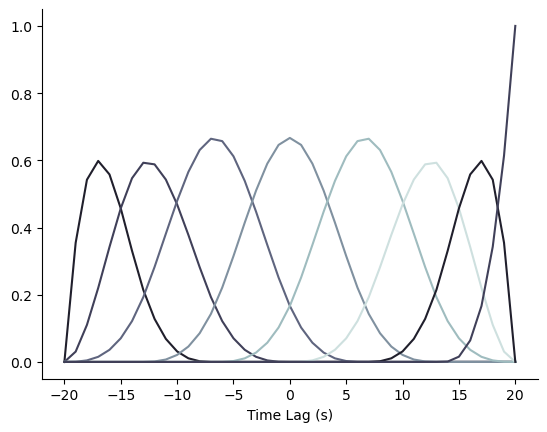

In [55]:
from patsy import dmatrix
# quick illustrationo of the regression splines
x=np.sort(peri_binned.bins.unique())
splines = dmatrix("bs(x, df=8, degree=3, include_intercept=False) -1", {"x":x}, return_type="dataframe").values
_, ax = plt.subplots(1,1)
ax.set_prop_cycle(color=sns.color_palette("bone",6))
ax.plot(x, splines)
ax.set_xlabel("Time Lag (s)")
sns.despine()
splines = splines/splines.sum(axis=0)

R[write to console]: boundary (singular) fit: see help('isSingular')



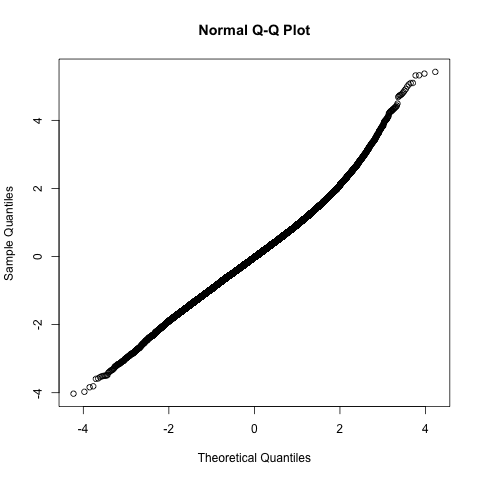

In [56]:
%%R -i peri_binned -o all_anova -o all_model
m <- lmer('df ~ 1 +  factor(day)*bs(bins, df=8, degree=3)*factor(cs)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = peri_binned)
all_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
all_anova <- anova(m)

In [57]:
all_anova['Significance'] = all_anova['Pr(>F)'].apply(check_significance)
all_model['Significance'] = all_model['Pr(>|t|)'].apply(check_significance)

display(all_anova, all_model)
main_train_fig_stats.update({'g_peri_bout_anovas': all_anova,
                             'g_peri_bout_model':   all_model
                            })

Sum Sq   Mean Sq  \
factor(day)                                          2.884610  1.442305   
bs(bins, df = 8, degree = 3)                        45.153501  5.644188   
factor(cs)                                           0.524605  0.524605   
factor(day):bs(bins, df = 8, degree = 3)            27.509157  1.719322   
factor(day):factor(cs)                               1.646604  0.823302   
bs(bins, df = 8, degree = 3):factor(cs)             76.321973  9.540247   
factor(day):bs(bins, df = 8, degree = 3):factor...  47.090030  2.943127   

                                                    NumDF         DenDF  \
factor(day)                                             2  41836.700554   
bs(bins, df = 8, degree = 3)                            8     12.959192   
factor(cs)                                              1  42096.197252   
factor(day):bs(bins, df = 8, degree = 3)               16  40323.969531   
factor(day):factor(cs)                                  2  41791.208588   
bs(bins, df = 8, degree = 3):factor(cs)                 8  41163.499133   
factor(day):bs(bins, df = 8, degree = 3):factor...     16  40148.254479   

                                                     F value        Pr(>F)  \
factor(day)                                         1.480018  2.276456e-01   
bs(bins, df = 8, degree = 3)                        5.791769  2.814566e-03   
factor(cs)                                          0.538322  4.631329e-01   
factor(day):bs(bins, df = 8, degree = 3)            1.764278  2.972979e-02   
factor(day):factor(cs)                              0.844829  4.296381e-01   
bs(bins, df = 8, degree = 3):factor(cs)             9.789699  1.099936e-13   
factor(day):bs(bins, df = 8, degree = 3):factor...  3.020082  4.260088e-05   

                                                   Significance  
factor(day)                                                  ns  
bs(bins, df = 8, degree = 3)                                 **  
factor(cs)                                                   ns  
factor(day):bs(bins, df = 8, degree = 3)                      *  
factor(day):factor(cs)                                       ns  
bs(bins, df = 8, degree = 3):factor(cs)                    ****  
factor(day):bs(bins, df = 8, degree = 3):factor...         ****

Estimate  Std. Error  \
(Intercept)                                         0.076697    0.083545   
factor(day)2                                       -0.054013    0.096580   
factor(day)3                                       -0.011407    0.094764   
bs(bins, df = 8, degree = 3)1                       0.058091    0.139558   
bs(bins, df = 8, degree = 3)2                      -0.131678    0.114875   
bs(bins, df = 8, degree = 3)3                       0.316930    0.140102   
bs(bins, df = 8, degree = 3)4                      -0.484861    0.179251   
bs(bins, df = 8, degree = 3)5                      -0.068200    0.296529   
bs(bins, df = 8, degree = 3)6                      -0.494373    0.138089   
bs(bins, df = 8, degree = 3)7                      -0.102416    0.185022   
bs(bins, df = 8, degree = 3)8                      -0.184961    0.136768   
factor(cs)+                                        -0.017291    0.101383   
factor(day)2:bs(bins, df = 8, degree = 3)1          0.200887    0.186403   
factor(day)3:bs(bins, df = 8, degree = 3)1          0.001749    0.182903   
factor(day)2:bs(bins, df = 8, degree = 3)2         -0.253823    0.142614   
factor(day)3:bs(bins, df = 8, degree = 3)2          0.133641    0.139969   
factor(day)2:bs(bins, df = 8, degree = 3)3          0.183710    0.149914   
factor(day)3:bs(bins, df = 8, degree = 3)3         -0.083099    0.147105   
factor(day)2:bs(bins, df = 8, degree = 3)4          0.133496    0.133116   
factor(day)3:bs(bins, df = 8, degree = 3)4          0.204832    0.130677   
factor(day)2:bs(bins, df = 8, degree = 3)5         -0.111271    0.144780   
factor(day)3:bs(bins, df = 8, degree = 3)5         -0.093307    0.142094   
factor(day)2:bs(bins, df = 8, degree = 3)6          0.261488    0.157381   
factor(day)3:bs(bins, df = 8, degree = 3)6          0.249792    0.154434   
factor(day)2:bs(bins, df = 8, degree = 3)7         -0.361074    0.160075   
factor(day)3:bs(bins, df = 8, degree = 3)7         -0.191253    0.157073   
factor(day)2:bs(bins, df = 8, degree = 3)8         -0.116097    0.136440   
factor(day)3:bs(bins, df = 8, degree = 3)8         -0.056053    0.133885   
factor(day)2:factor(cs)+                            0.016365    0.139576   
factor(day)3:factor(cs)+                            0.158234    0.137037   
bs(bins, df = 8, degree = 3)1:factor(cs)+           0.145323    0.195672   
bs(bins, df = 8, degree = 3)2:factor(cs)+          -0.084784    0.149688   
bs(bins, df = 8, degree = 3)3:factor(cs)+           0.210853    0.157365   
bs(bins, df = 8, degree = 3)4:factor(cs)+           0.008550    0.139703   
bs(bins, df = 8, degree = 3)5:factor(cs)+          -0.167798    0.151962   
bs(bins, df = 8, degree = 3)6:factor(cs)+           0.252181    0.165203   
bs(bins, df = 8, degree = 3)7:factor(cs)+          -0.187427    0.168032   
bs(bins, df = 8, degree = 3)8:factor(cs)+           0.085855    0.143220   
factor(day)2:bs(bins, df = 8, degree = 3)1:fact... -0.117441    0.269375   
factor(day)3:bs(bins, df = 8, degree = 3)1:fact... -0.056369    0.264476   
factor(day)2:bs(bins, df = 8, degree = 3)2:fact...  0.413476    0.205967   
factor(day)3:bs(bins, df = 8, degree = 3)2:fact... -0.089811    0.202230   
factor(day)2:bs(bins, df = 8, degree = 3)3:fact... -0.166496    0.216619   
factor(day)3:bs(bins, df = 8, degree = 3)3:fact... -0.034628    0.212681   
factor(day)2:bs(bins, df = 8, degree = 3)4:fact... -0.257547    0.192124   
factor(day)3:bs(bins, df = 8, degree = 3)4:fact... -0.640748    0.188652   
factor(day)2:bs(bins, df = 8, degree = 3)5:fact...  0.253584    0.209092   
factor(day)3:bs(bins, df = 8, degree = 3)5:fact...  0.038999    0.205302   
factor(day)2:bs(bins, df = 8, degree = 3)6:fact... -0.230955    0.227399   
factor(day)3:bs(bins, df = 8, degree = 3)6:fact... -0.468126    0.223267   
factor(day)2:bs(bins, df = 8, degree = 3)7:fact...  0.496405    0.231307   
factor(day)3:bs(bins, df = 8, degree = 3)7:fact...  0.063311    0.227103   
factor(day)2:bs(bins, df

### further quantification

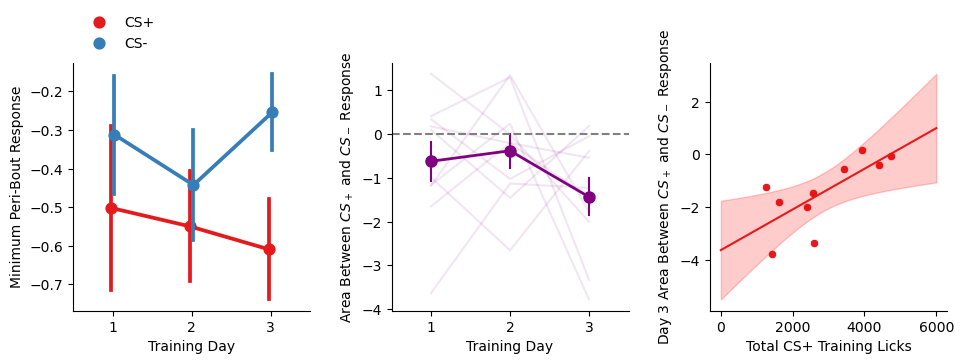

In [11]:
fig, ax = plt.subplots(1,3, figsize=(10,4))

# get min responses from 0 to 5s and plot
mn_loc =  mn_peri_bout.groupby(['day','cs']).mean().T.loc[0:5].idxmin(axis=0)
mn_rp = {}
for i,v in mn_loc.items():
    tmp = mn_peri_bout.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp = pd.DataFrame(mn_rp).T
mn_rp.index = mn_rp.index.set_names(['day', 'cs'])
mn_rp = mn_rp.stack().rename('df')

g = sns.pointplot(mn_rp.reset_index(), x='day', y='df',hue='cs',
                  errorbar='se',dodge=True, ax=ax[0])
g.legend(g.get_legend_handles_labels()[0], ['CS+', 'CS-'], 
         loc = 'lower left', bbox_to_anchor = (0,1), frameon = False)
g.set_xlabel("Training Day")
g.set_ylabel("Minimum Peri-Bout Response")

abc = mn_peri_bout.swaplevel('day','cs').loc['+'].T.loc[0:5] - mn_peri_bout.swaplevel('day','cs').loc['-'].T.loc[0:5]
abc = abc.apply(lambda x: np.trapz(x.values, x=x.index), axis=0)#/mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
abc = abc.rename('df').reset_index() # mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
sns.lineplot(abc, x='day',y='df', errorbar='se', marker='o', markeredgewidth=0, 
             color = 'purple', err_style='bars', markersize=9, linewidth=2,
             ax=ax[1])
g = sns.lineplot(abc, x='day',y='df', errorbar='se', 
                 palette=['purple']*abc.mouse.unique().size,
                 hue='mouse',
                 ax=ax[1], alpha=0.1)
g.get_legend().remove()
ax[1].axhline(0, c = 'gray', ls = '--')
ax[1].set_ylabel("Area Between $CS_+$ and $CS_-$ Response")
ax[1].set_xlabel("Training Day")
ax[1].set_xlim(0.5,3.5)
ax[1].set_xticks(np.arange(1,4))



diff_d3 = abc.set_index(['day','mouse']).df.loc[3]
train_licks = reindex(training.raw_data.apply(lambda x: x.events['left_licks'].size).droplevel('trial'))[0]
train_licks = train_licks.groupby(['mouse','cs']).sum().loc[:, '+'].loc[diff_d3.index]
df = pd.concat({'licks':train_licks, 'diff': diff_d3}, axis=1)
d3vlicks = smf.ols('diff ~ licks', df).fit()
x = np.linspace(0,6000, 100)

pred = d3vlicks.get_prediction({'licks': x})
sns.scatterplot(data=df, x='licks', y='diff', ax = ax[2])
ax[2].plot(x, pred.predicted_mean)
ax[2].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1], color = 'r', alpha = 0.2)
ax[2].set(xlabel = 'Total CS+ Training Licks', ylabel = r"Day 3 Area Between $CS_+$ and $CS_-$ Response")

# format figure
sns.despine()
fig.tight_layout(pad = 2.)

# # save figure
fig.savefig(os.path.join(peri_stim_pdfs_train ,'additional_quantification.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'additional_quantification.svg'))


#### stats

##### stats - minimum response

F Value  Num DF  Den DF    Pr > F Significance
cs      13.919528     1.0     9.0  0.004691           **
day      0.241200     2.0    18.0  0.788184           ns
cs:day   1.075432     2.0    18.0  0.362084           ns

t   p-value   df  Corrected p-value Significance
day                                                         
1   -1.389049  0.198224  9.0           0.357155           ns
2   -1.010741  0.338540  9.0           0.357155           ns
3   -3.514743  0.006569  9.0           0.019579            *

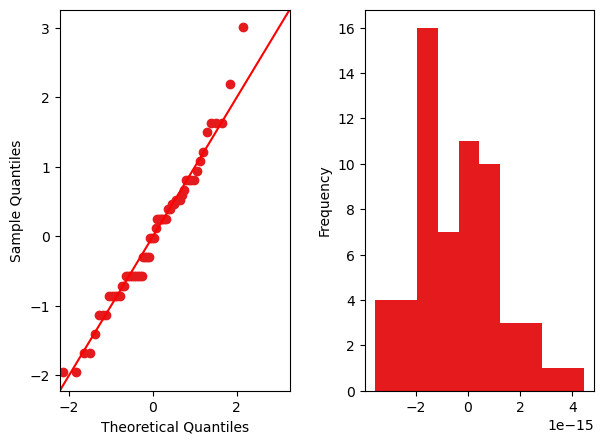

In [58]:
# fit the anova
mn_rp_anova = AnovaRM(mn_rp.reset_index(), 'df', 'mouse', 
                      within=['cs','day']).fit().summary().tables[0]
mn_rp_anova['Significance'] = mn_rp_anova['Pr > F'].apply(check_significance)

# validate normal residuals
resid = smf.ols('day~C(cs,Sum)*C(day,Sum)*C(mouse,Sum)', 
                mn_rp.reset_index()).fit().resid

fig, ax = plt.subplots(1,2)
sm.qqplot(resid, fit=True, line='45', ax = ax[0]);
resid.plot.hist(ax=ax[1])
fig.tight_layout(pad = 2.)

mn_rp_stats = mn_rp.unstack('cs').groupby('day').apply(lambda x: st.ttest_rel(x['+'], x['-'])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t', 'p-value', 'df')))
mn_rp_stats['Corrected p-value'] = multipletests(mn_rp_stats['p-value'], method='holm-sidak')[1]
mn_rp_stats['Significance'] = mn_rp_stats['Corrected p-value'].apply(check_significance)

display(mn_rp_anova, mn_rp_stats)
main_train_fig_stats.update({'h_min_resp_anova': mn_rp_anova,
                             'h_min_resp_stats': mn_rp_stats})

##### stats - area between curves correlation

In [59]:
# fit the anova

abc_friedman = st.friedmanchisquare(abc.set_index(['day','mouse']).loc[1].df, 
                                    abc.set_index(['day','mouse']).loc[2].df,
                                    abc.set_index(['day','mouse']).loc[3].df)

abc_friedman = pd.Series(abc_friedman, index=('statistic', 'p-value')).rename('ABC Friedman Test').to_frame().T
abc_friedman['Significance'] = abc_friedman['p-value'].apply(check_significance)


abc_stats = (abc.set_index(['day','mouse'])
                .groupby('day').df
                .apply(lambda x: st.wilcoxon(x))
                .apply(lambda x: pd.Series(x, index=('W', 'p-value')))
            )
abc_stats['Corrected p-value'] = multipletests(abc_stats['p-value'], method='holm-sidak')[1]
abc_stats['Significance'] = abc_stats['Corrected p-value'].apply(check_significance)

display(abc_friedman, abc_stats)
main_train_fig_stats.update({'i_ABC_friedman': abc_friedman,
                             'i_ABC_stats': abc_stats})

statistic   p-value Significance
ABC Friedman Test        1.4  0.496585           ns

statistic   p-value  Corrected p-value Significance
day                                                     
1         18.0  0.375000           0.609375           ns
2         19.0  0.431641           0.609375           ns
3          2.0  0.005859           0.017475            *

##### stats - area between curves correlation

In [60]:
d3vlicks_coef = pd.DataFrame(d3vlicks.summary().tables[1])
d3vlicks_coef.columns = d3vlicks_coef.iloc[0].astype(str)
d3vlicks_coef = d3vlicks_coef.set_index('').iloc[1:]
d3vlicks_r = pd.Series({'R2': d3vlicks.rsquared}).rename("Day 3 ABC vs Cummulative Training Licks Correlation").to_frame().T

display(d3vlicks_coef, d3vlicks_r)

main_train_fig_stats.update({'j_d3_ABC_lick_corr_coef': d3vlicks_coef,
                             'j_d3_ABC_lick_corr_r2': d3vlicks_r})

/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


0                coef    std err          t   P>|t|     [0.025     0.975]
                                                                         
Intercept     -3.6161      0.809     -4.469   0.002     -5.482     -1.750
licks          0.0008      0.000      2.916   0.019      0.000      0.001

R2
Day 3 ABC vs Cummulative Training Licks Correla...  0.515273

In [61]:
with pd.ExcelWriter('stats/raw/train_stats.xlsx') as writer:  
    for k,v in main_train_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within session analysis

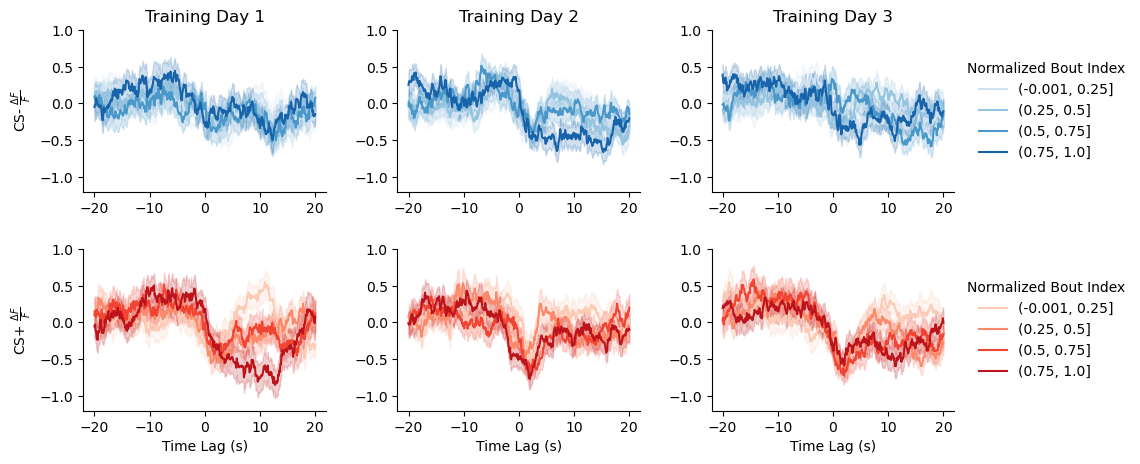

In [13]:
fig, ax = plt.subplots(2,3, figsize=(10,5))

df = peri_bout.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(3):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<2 else True)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<2 else True)
    ax[0,i].set_ylim(-1.2,1)
    ax[1,i].set_ylim(-1.2,1)
    ax[0,i].set_title(f"Training Day {i+1}")
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)")

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$")
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$")
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")

fig.savefig(os.path.join(peri_stim_pdfs_train ,'supp_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'supp_within_session.svg'))

#### stats

##### stats - day 1

In [16]:
peri_binned['bout_fraction'] = peri_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
day1_binned = peri_binned.loc[peri_binned.day==1]

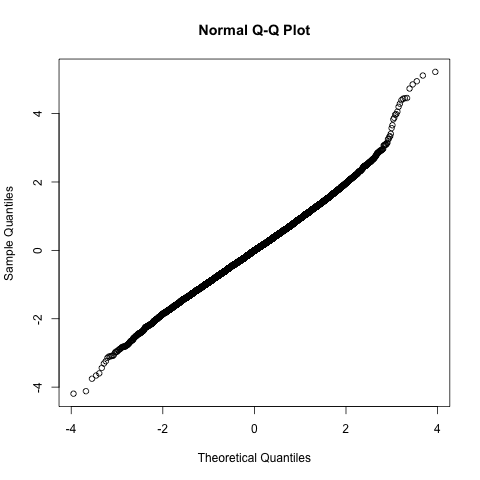

In [17]:
%%R -i day1_binned -o day1_anova -o day1_model
m <- lmer('df ~ 1+ bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_binned)
day1_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_anova <- anova(m)

In [18]:
day1_anova['Significance'] = day1_anova['Pr(>F)'].apply(check_significance)
day1_model['Significance'] = day1_model['Pr(>|t|)'].apply(check_significance)

display(day1_anova, day1_model)


supp_train_fig_peri_stats = {'day1_peri_bout_anovas': day1_anova,
                             'day1_peri_bout_stat':   day1_model}

Sum Sq    Mean Sq  \
bout_fraction                                         2.675181   2.675181   
factor(cs)                                            0.035237   0.035237   
bs(bins, df = 8, degree = 3)                         46.656293   5.832037   
bout_fraction:factor(cs)                              0.016400   0.016400   
bout_fraction:bs(bins, df = 8, degree = 3)          150.106905  18.763363   
factor(cs):bs(bins, df = 8, degree = 3)              25.062599   3.132825   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   44.353336   5.544167   

                                                    NumDF         DenDF  \
bout_fraction                                           1  12698.570052   
factor(cs)                                              1  12608.668999   
bs(bins, df = 8, degree = 3)                            8     29.029983   
bout_fraction:factor(cs)                                1  12698.566645   
bout_fraction:bs(bins, df = 8, degree = 3)              8  12698.573609   
factor(cs):bs(bins, df = 8, degree = 3)                 8  12239.124181   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  12698.573061   

                                                      F value        Pr(>F)  \
bout_fraction                                        2.897327  8.875102e-02   
factor(cs)                                           0.038163  8.451189e-01   
bs(bins, df = 8, degree = 3)                         6.316329  9.460339e-05   
bout_fraction:factor(cs)                             0.017762  8.939791e-01   
bout_fraction:bs(bins, df = 8, degree = 3)          20.321472  7.480036e-31   
factor(cs):bs(bins, df = 8, degree = 3)              3.392975  6.739276e-04   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   6.004554  1.006773e-07   

                                                   Significance  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                               ****  
bout_fraction:factor(cs)                                     ns  
bout_fraction:bs(bins, df = 8, degree = 3)                 ****  
factor(cs):bs(bins, df = 8, degree = 3)                     ***  
bout_fraction:factor(cs):bs(bins, df = 8, degre...         ****

Estimate  Std. Error  \
(Intercept)                                         0.221701    0.140815   
bout_fraction                                      -0.293796    0.223316   
factor(cs)+                                        -0.036746    0.188099   
bs(bins, df = 8, degree = 3)1                       0.090534    0.261227   
bs(bins, df = 8, degree = 3)2                      -0.368707    0.199034   
bs(bins, df = 8, degree = 3)3                      -0.090845    0.248887   
bs(bins, df = 8, degree = 3)4                      -0.618528    0.232262   
bs(bins, df = 8, degree = 3)5                      -0.278926    0.323339   
bs(bins, df = 8, degree = 3)6                      -0.258866    0.237583   
bs(bins, df = 8, degree = 3)7                      -0.622369    0.265466   
bs(bins, df = 8, degree = 3)8                      -0.323603    0.222944   
bout_fraction:factor(cs)+                           0.042666    0.320139   
bout_fraction:bs(bins, df = 8, degree = 3)1        -0.015759    0.430939   
bout_fraction:bs(bins, df = 8, degree = 3)2         0.480755    0.329026   
bout_fraction:bs(bins, df = 8, degree = 3)3         0.782451    0.346447   
bout_fraction:bs(bins, df = 8, degree = 3)4         0.229147    0.306379   
bout_fraction:bs(bins, df = 8, degree = 3)5         0.409274    0.333961   
bout_fraction:bs(bins, df = 8, degree = 3)6        -0.477313    0.363642   
bout_fraction:bs(bins, df = 8, degree = 3)7         1.094842    0.369952   
bout_fraction:bs(bins, df = 8, degree = 3)8         0.310834    0.315250   
factor(cs)+:bs(bins, df = 8, degree = 3)1          -0.015769    0.363190   
factor(cs)+:bs(bins, df = 8, degree = 3)2          -0.077170    0.277401   
factor(cs)+:bs(bins, df = 8, degree = 3)3           0.323523    0.292345   
factor(cs)+:bs(bins, df = 8, degree = 3)4          -0.311897    0.258599   
factor(cs)+:bs(bins, df = 8, degree = 3)5           0.538351    0.281996   
factor(cs)+:bs(bins, df = 8, degree = 3)6           0.442277    0.306623   
factor(cs)+:bs(bins, df = 8, degree = 3)7          -0.174275    0.312143   
factor(cs)+:bs(bins, df = 8, degree = 3)8          -0.137245    0.265819   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.264304    0.617780   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.001866    0.471680   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.183479    0.496655   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.655398    0.439215   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.458454    0.478756   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.377511    0.521304   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.067737    0.530350   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.410411    0.451932   

                                                              df   t value  \
(Intercept)                                           158.449643  1.574411   
bout_fraction                                       12698.556745 -1.315603   
factor(cs)+                                         12608.668999 -0.195354   
bs(bins, df = 8, degree = 3)1                         367.576071  0.346573   
bs(bins, df = 8, degree = 3)2                         294.734918 -1.852485   
bs(bins, df = 8, degree = 3)3                          50.468572 -0.365005   
bs(bins, df = 8, degree = 3)4                          37.650427 -2.663064   
bs(bins, df = 8, degree = 3)5                          18.890540 -0.862645   
bs(bins, df = 8, degree = 3)6                          98.429753 -1.089581   
bs(bins, df = 8, degree = 3)7                          48.222543 -2.344443   
bs(bins, df = 8, degree = 3)8                          53.193250 -1.451496   
bout_fraction:factor(cs)+                           12698.566645  0.133274   
bout_fraction:bs(bins, df = 8, degree = 3)1         12698.565985 -0.036570   
bout_fraction:bs(bins, df = 8, degree = 3)2         12698.570920  1.461149   
bout_fraction:bs(bins, df = 8, degree = 3)3         12698.565013  2.2

##### stats - within session all days

R[write to console]: boundary (singular) fit: see help('isSingular')



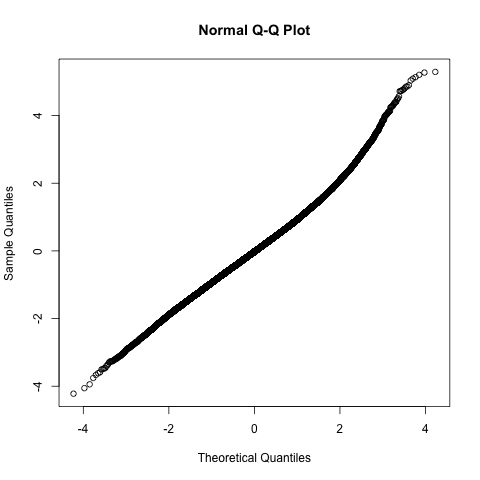

In [19]:
%%R -i peri_binned -o peri_within_anova -o peri_within_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_binned)
peri_within_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_anova <- anova(m)

In [20]:
peri_within_anova['Significance'] = peri_within_anova['Pr(>F)'].apply(check_significance)
peri_within_model['Significance'] = peri_within_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_anova, peri_within_model)

supp_train_fig_peri_stats.update({'peri_within_anova': peri_within_anova,
                                  'peri_within_model': peri_within_model
                                  })

Sum Sq    Mean Sq  \
factor(day)                                           4.026934   2.013467   
bout_fraction                                         0.002365   0.002365   
factor(cs)                                            2.330058   2.330058   
bs(bins, df = 8, degree = 3)                         60.185357   7.523170   
factor(day):bout_fraction                             4.174813   2.087407   
factor(day):factor(cs)                                1.745201   0.872600   
bout_fraction:factor(cs)                              1.818281   1.818281   
factor(day):bs(bins, df = 8, degree = 3)             36.411184   2.275699   
bout_fraction:bs(bins, df = 8, degree = 3)          272.700438  34.087555   
factor(cs):bs(bins, df = 8, degree = 3)              13.189198   1.648650   
factor(day):bout_fraction:factor(cs)                  1.375260   0.687630   
factor(day):bout_fraction:bs(bins, df = 8, degr...   51.410621   3.213164   
factor(day):factor(cs):bs(bins, df = 8, degree ...   68.693519   4.293345   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   14.268692   1.783587   
factor(day):bout_fraction:factor(cs):bs(bins, d...   93.120698   5.820044   

                                                    NumDF         DenDF  \
factor(day)                                             2  42389.708437   
bout_fraction                                           1  42444.840696   
factor(cs)                                              1  42412.793535   
bs(bins, df = 8, degree = 3)                            8     25.799119   
factor(day):bout_fraction                               2  42444.793272   
factor(day):factor(cs)                                  2  42384.776939   
bout_fraction:factor(cs)                                1  42444.868014   
factor(day):bs(bins, df = 8, degree = 3)               16  42297.916108   
bout_fraction:bs(bins, df = 8, degree = 3)              8  42444.843443   
factor(cs):bs(bins, df = 8, degree = 3)                 8  42361.088247   
factor(day):bout_fraction:factor(cs)                    2  42444.698378   
factor(day):bout_fraction:bs(bins, df = 8, degr...     16  42444.836666   
factor(day):factor(cs):bs(bins, df = 8, degree ...     16  42278.272266   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  42444.846849   
factor(day):bout_fraction:factor(cs):bs(bins, d...     16  42444.834597   

                                                      F value        Pr(>F)  \
factor(day)                                          2.086868  1.240879e-01   
bout_fraction                                        0.002451  9.605162e-01   
factor(cs)                                           2.415000  1.201854e-01   
bs(bins, df = 8, degree = 3)                         7.797427  2.769215e-05   
factor(day):bout_fraction                            2.163503  1.149345e-01   
factor(day):factor(cs)                               0.904411  4.047880e-01   
bout_fraction:factor(cs)                             1.884566  1.698233e-01   
factor(day):bs(bins, df = 8, degree = 3)             2.358660  1.654465e-03   
bout_fraction:bs(bins, df = 8, degree = 3)          35.330217  3.175166e-56   
factor(cs):bs(bins, df = 8, degree = 3)              1.708751  9.081780e-02   
factor(day):bout_fraction:factor(cs)                 0.712698  4.903256e-01   
factor(day):bout_fraction:bs(bins, df = 8, degr...   3.330300  6.845213e-06   
factor(day):factor(cs):bs(bins, df = 8, degree ...   4.449859  6.271264e-09   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   1.848607  6.341509e-02   
factor(day):bout_fraction:factor(cs):bs(bins, d...   6.032213  1.615505e-13   

                                                   Significance  
factor(day)                                                  ns  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                               ****  
factor(day):bout_fraction  

Estimate  Std. Error  \
(Intercept)                                         0.223808    0.141383   
factor(day)2                                       -0.411054    0.183935   
factor(day)3                                       -0.275864    0.180734   
bout_fraction                                      -0.293796    0.228280   
factor(cs)+                                        -0.039329    0.192227   
...                                                      ...         ...   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.324627    0.724161   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.780857    0.748864   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,... -0.111949    0.736727   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -0.122662    0.638136   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,... -0.028118    0.627794   

                                                              df   t value  \
(Intercept)                                           461.682119  1.582998   
factor(day)2                                        42294.163760 -2.234776   
factor(day)3                                        42255.126905 -1.526353   
bout_fraction                                       42444.928055 -1.286998   
factor(cs)+                                         42307.871189 -0.204596   
...                                                          ...       ...   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  42444.806981  0.448280   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  42444.877328  1.042722   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  42444.877184 -0.151954   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  42444.816692 -0.192219   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  42444.841279 -0.044789   

                                                    Pr(>|t|) Significance  
(Intercept)                                         0.114107           ns  
factor(day)2                                        0.025437            *  
factor(day)3                                        0.126929           ns  
bout_fraction                                       0.198102           ns  
factor(cs)+                                         0.837889           ns  
...                                                      ...          ...  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.653954           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.297083           ns  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.879224           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.847572           ns  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.964276           ns  

[108 rows x 6 columns]

In [21]:
with pd.ExcelWriter('stats/raw/supp_train_peri_stats.xlsx') as writer:  
    for k,v in supp_train_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)

# Testing

In [12]:
# load testing data
testing = analysis(norm_method, t_dur, 
                   ds_freq = 1, ex = ex, detrend = detrend, 
                   detrend_method = detrend_method)
testing.load_append_save(Path('data/cohort1/testing.npy'))
testing.load_append_save(Path('data/cohort2/testing.npy'))
testing.compute()

first_lick_test = time_lock_lick(testing, 0)

loading data from file...
loading data from file...
recomputing...


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline


successful


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/utils.py:204: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_o

### plot time lock mean traces

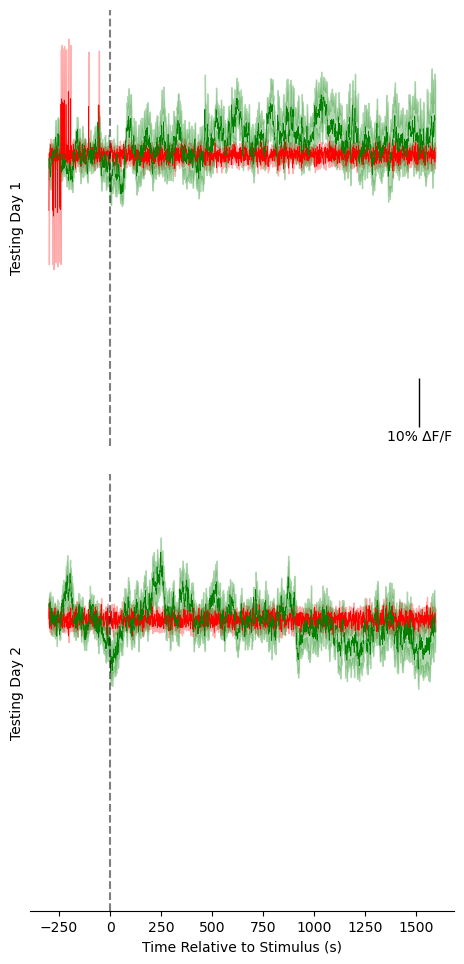

In [13]:
# create subplot
fig, ax = plt.subplots(2,1, figsize = (5,10))
# plot the traces
first_lick_test.plot_both(ax = ax, show = False)
vertbar = AnchoredSizeBar(ax[1].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[0].add_artist(vertbar)

# format the plots
ax[0].tick_params(left=False,labelleft=False, bottom = False, labelbottom = False)
ax[1].tick_params(left=False,labelleft=False)
sns.despine(ax = ax[0], left = True, bottom = True)
sns.despine(ax = ax[1], left = True)
ax[1].set_ylabel("Testing Day 2")
ax[1].set_title("")
ax[1].set_ylim(-.6,.3)
ax[0].set_ylabel("Testing Day 1")
ax[0].set_title("")
ax[0].set_ylim(-.6,.3)
fig.tight_layout(pad = 2.)
fig.savefig(os.path.join(first_lick_test_pdfs, 'full_trace.pdf'))
fig.savefig(os.path.join(first_lick_test_svgs, 'full_trace.svg'))


In [14]:
#reload the data without normalizing
testing = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
testing.load_append_save(Path('data/cohort1/testing.npy'))
testing.load_append_save(Path('data/cohort2/testing.npy'))
testing.compute()

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = testing.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate baseline with a moving average
bl = testing.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
testing.t_prestim = -new_t[0]
testing.t_endrec = new_t[-1]
testing.all_490 = testing.all_490.loc[bl.index]

# normalize relative to the baseline
testing.all_490 = (testing.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
testing.all_490 = (testing.all_490 - testing.all_490.loc[:0].mean(axis=0))/testing.all_490.loc[:0].std(axis=0)

loading data from file...
loading data from file...
recomputing...
successful


/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/photometry/../../photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


In [15]:
# compute lick bout times for testing
np.random.seed(99)

setup = pd.read_csv('data/setup.csv', index_col = 0)
for i,v in testing.raw_data.items():
    day = i[0][-1]
    mouse = i[1]
    
    # use setup file to identify left v right licks as cs+ v cs- licks
    csp_s = setup.loc[mouse, f'd{day}_side']
    csm_s = 'left' if csp_s == 'right' else 'right'
    testing.raw_data.loc[i].events['csp'] = v.events[csp_s + '_licks']
    testing.raw_data.loc[i].events['csm'] = v.events[csm_s + '_licks']
    
    # combine cs+ and cs- lick times and construct an array of labels
    cspl = testing.raw_data.loc[i].events['csp']
    csml = testing.raw_data.loc[i].events['csm'] 
    all_licks = np.concatenate((cspl, csml))
    labels = np.array(['p']*cspl.size + ['m']*csml.size)
    
    # sort labels for all lick events so we can identify bouts later
    sort_idx = all_licks.argsort()
    labels = labels[sort_idx]
    all_licks = all_licks[sort_idx]
    
    # identify bout starts by thresholding the ili over all licks
    ili = np.append(bout_thresh + 1, all_licks[1:] - all_licks[:-1] )
    all_bouts = all_licks[ili>bout_thresh]
    
    # determine whether bouts were initiated by a cs+ or cs- lick
    all_bout_labels = labels[ili>bout_thresh]
    csp_bouts = all_bouts[all_bout_labels == 'p']
    csm_bouts = all_bouts[all_bout_labels == 'm']
    
    # update the field
    testing.raw_data.loc[i].events['all_csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['all_csm_bouts'] = csm_bouts
    
    
    # remove bouts near the end that cannot be used for peri-bout analyses
    csp_bn = get_bn(testing.raw_data.loc[i], 'csp', 'all_csp_bouts').values
    csp_bouts = csp_bouts[csp_bn>1]
    csp_bouts = csp_bouts[csp_bouts<testing.t_endrec - peri_window - 1]
    
    csm_bn = get_bn(testing.raw_data.loc[i], 'csm', 'all_csm_bouts').values
    csm_bouts = csm_bouts[csm_bn>1]
    csm_bouts = csm_bouts[csm_bouts<testing.t_endrec - peri_window - 1]
    
    testing.raw_data.loc[i].events['csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['csm_bouts'] = csm_bouts
    
    testing.raw_data.loc[i].events['all_bouts'] = all_bouts  

In [16]:
# check how many bouts we are removing due to the moving average
max_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).max()
mn_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmn_rm_bouts:', mn_rm_bouts)

max removed bouts: 1 
mn_rm_bouts: 0.3


In [17]:
# # get peri-bout activity for all cs+ and cs- bouts
    
csp_bout = peri_event(testing, 'csp_bouts', peri_window, norm = peri_bout_norm_test).T
csm_bout = peri_event(testing, 'csm_bouts', peri_window, norm = peri_bout_norm_test).T

# combine into one dataframe
peri_test = pd.concat({'+':csp_bout, '-':csm_bout}, names = ['cs'])
peri_test.columns.name = 'time'

# some reformatting for easier access
peri_test = peri_test.stack().rename('df').reset_index()
peri_test['day'] = peri_test.cond.str.extract('_(.)').astype(int)
peri_test = peri_test.set_index(['day','cs','mouse', 'event', 'time']).df.unstack('time')

# select only mice that had at least 3 bouts for each flavor on both days
nb_test = peri_test.groupby(['cs','day','mouse']).size().unstack(['cs','day'])
good_mice = (nb_test>=3).all(axis=1)
good_mice = good_mice.loc[good_mice].index
nb_test = nb_test.loc[good_mice].stack(['cs','day'])
peri_test = (peri_test.swaplevel('day','mouse')
                      .loc[good_mice]
                      .swaplevel('day','mouse')
            )

# get mean response
mn_peri_test = peri_test.groupby(['day','cs','mouse']).mean()
mn_peri_test = (mn_peri_test.unstack(['day','cs'])
                            .dropna()
                            .stack(['cs', 'day'])
                            .swaplevel('mouse','day')
                            .sort_index()
               )

In [18]:

# seed the random number generator for random bout generation
np.random.seed(5)

# simmulate random lick bouts and get corresponding peri bout activity
ctl_test = []

with tqdm(total = niters_rand) as pbar:
    def randomize_test_bouts(pid):
        global ctl_test
        global testing
        end_lim = testing.all_490.index[-1]-peri_window-1
        for i,v in testing.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['all_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))
            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            rand_evs = np.sort(rand_evs) 
            # sample appropriate number of cs+ bouts
            csp = np.random.choice(rand_evs, v.events['all_csp_bouts'].size, replace = False)
            rand_evs = rand_evs[~np.isin(rand_evs, csp)]
            csp = np.random.choice(csp, v.events['csp_bouts'].size, replace = False)

            # sample appropriate number of cs- bouts
            csm = np.random.choice(rand_evs, v.events['all_csm_bouts'].size, replace = False)
            csm = np.random.choice(csm, v.events['csm_bouts'].size, replace = False)

            #save randomized bouts
            testing.raw_data.loc[i].events[f'rand_csp_{pid}'] = csp
            testing.raw_data.loc[i].events[f'rand_csm_{pid}'] = csp

        # get peri-bout data for random bouts and compute the mean response
        _d = pd.concat({'+': peri_event(testing, f'rand_csp_{pid}',  
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean(),
                        '-': peri_event(testing, f'rand_csm_{pid}', 
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean()
                       }, names = ['cs','time'])
        

        ctl_test.append(_d)


    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_test_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)
        
ctl_test = pd.concat(dict(enumerate(ctl_test)), axis=1, names = ['event'])
ctl_test = ctl_test.unstack('cs').T.reset_index()
ctl_test['day']= ctl_test.cond.str.extract('_(.)').astype(int)
ctl_test=ctl_test.set_index(['day','cs','mouse','event']).drop('cond', axis=1).sort_index()
ctl_test_mn = ctl_test.groupby(['day','cs','mouse']).mean()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


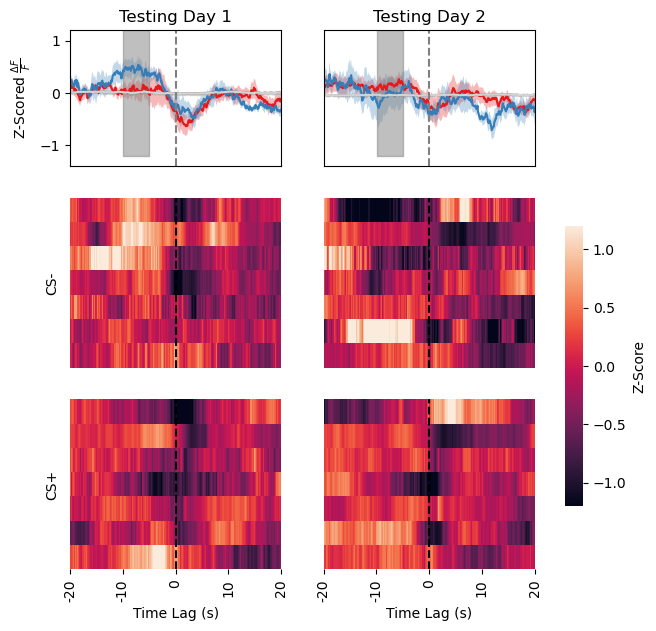

In [146]:
fig, ax = plot_peri( mn_peri_test, ctl_test_mn, 'Testing', peri_stim_test_figs,
                    'testing_all', figsize = (6,7), ylim = (-1.4,1.2), vmin = -1.2, vmax = 1.2, 
                    vlabel= r'Z-Score', ylabel =  r'Z-Scored $\frac{\Delta F}{F}$', save = False,);

for i in range(2):
    ax[0,i].fill_between([-10,-5], -1.2,1.2,color='gray', alpha=0.5)

fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_peri.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_peri.svg'))


#### individual mice

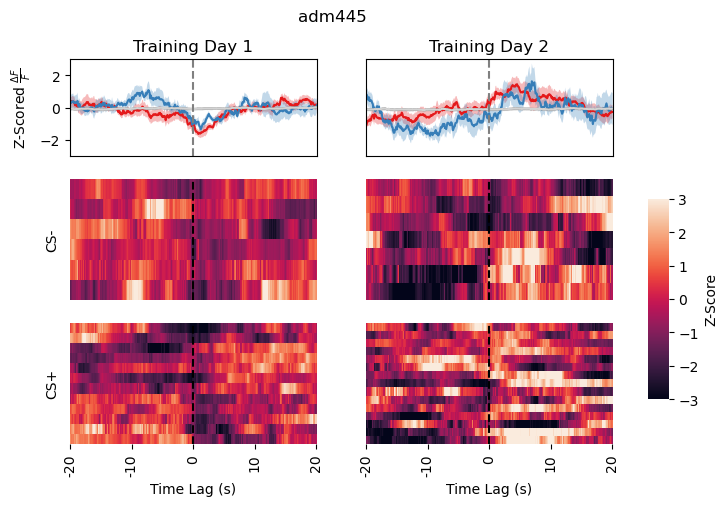

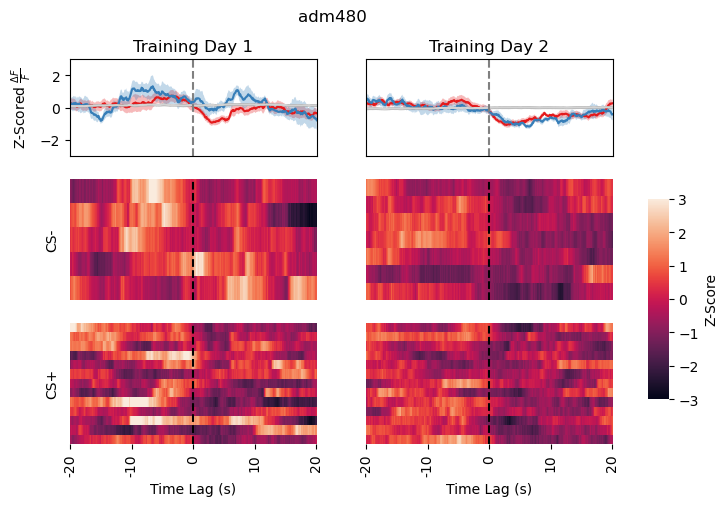

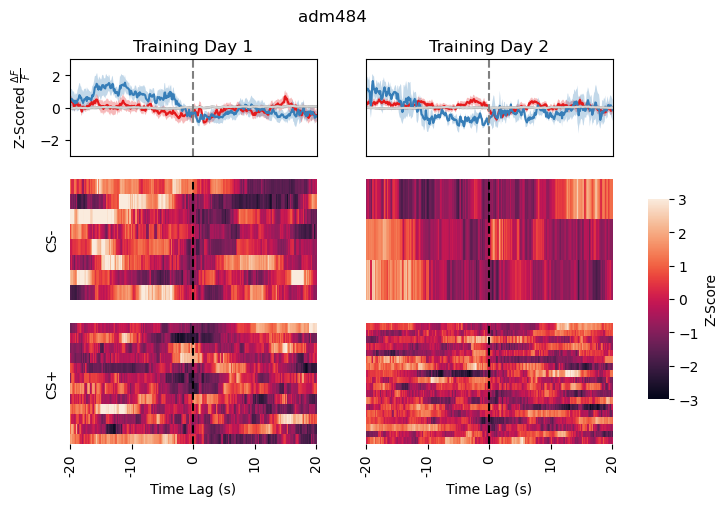

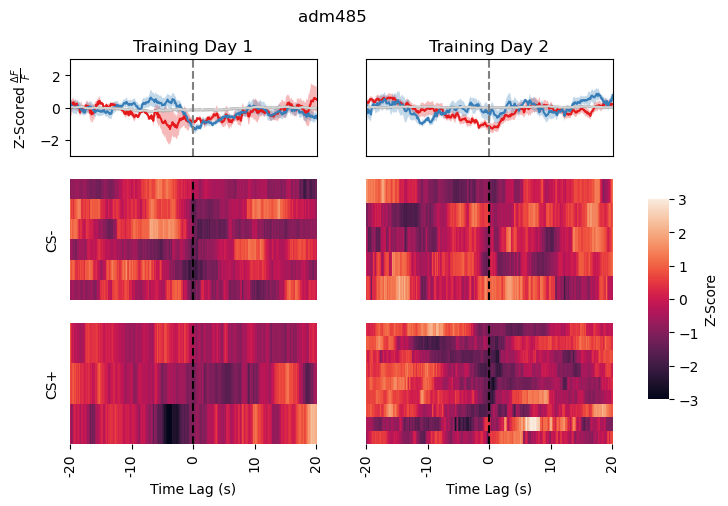

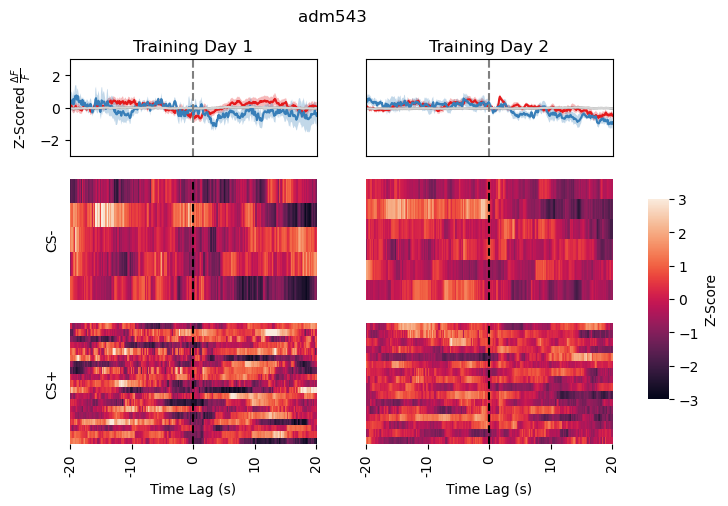

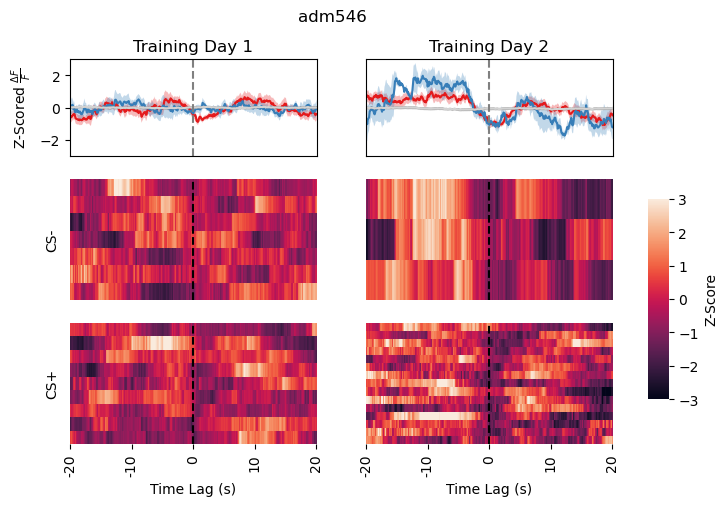

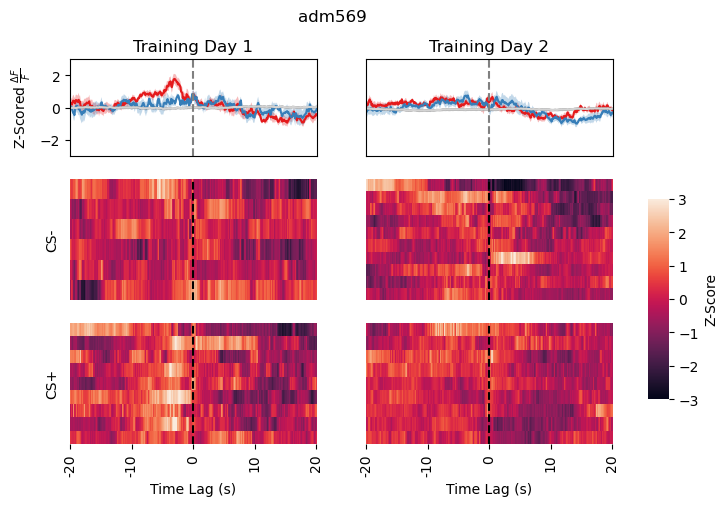

In [153]:
for i in mn_peri_test.index.get_level_values('mouse').unique():
    fig, _ = plot_peri(peri_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                        ctl = ctl_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                        save=False, vmin = -3, vmax=3, ylim = (-3,3));
    fig.suptitle(i)


In [ ]:
mn_peri_test_binned = bin_peri_bout(mn_peri_test, 1).stack().rename('df').reset_index()


day cs   mouse  event  bins        df  bout_fraction
0        1  +  adm445      0 -20.0 -0.522581            0.0
1        1  +  adm445      0 -19.0 -0.466657            0.0
2        1  +  adm445      0 -18.0 -0.848469            0.0
3        1  +  adm445      0 -17.0 -1.313987            0.0
4        1  +  adm445      0 -16.0 -0.347755            0.0
...    ... ..     ...    ...   ...       ...            ...
42594    3  -  adm571     17  16.0  1.704140            1.0
42595    3  -  adm571     17  17.0  1.295915            1.0
42596    3  -  adm571     17  18.0  0.682007            1.0
42597    3  -  adm571     17  19.0  1.051216            1.0
42598    3  -  adm571     17  20.0  0.830632            1.0

[42599 rows x 7 columns]

#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [238]:
nbouts = (nb_test.groupby(['day','cs']).mean().round(2).astype(str) + ' ± ' + nb_test.groupby(['day','cs']).sem().round(2).astype(str)).rename('bout number').to_frame()
display(nbouts)
main_test_fig_stats.update({'a_n_bouts': nbouts})

bout number
day cs              
1   +    11.0 ± 1.84
    -     6.14 ± 0.4
2   +   13.57 ± 1.31
    -    5.86 ± 0.94

##### stats - compare bout triggered averages

In [239]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')



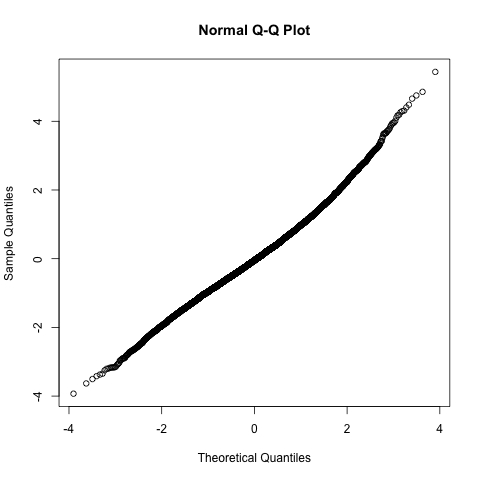

In [240]:
%%R -i peri_test_binned  -o test_anova  -o test_model
#-o test_per_day
m <- lmer('df ~ 1 + factor(day)*bs(bins, df=6,degree=3)*factor(cs) + (1 + bs(bins, df=6,degree=3)|mouse)', data = peri_test_binned)
test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
test_anova <- anova(m)

In [241]:
test_anova['Significance'] = test_anova['Pr(>F)'].apply(check_significance)
test_model['Significance'] = test_model['Pr(>|t|)'].apply(check_significance)

display(test_anova, test_model)
main_test_fig_stats.update({'a_test_anova_trace': test_anova,
                            'a_test_model' : test_model
                     })

Sum Sq   Mean Sq  \
factor(day)                                          0.045172  0.045172   
bs(bins, df = 6, degree = 3)                        31.399947  5.233324   
factor(cs)                                           0.436213  0.436213   
factor(day):bs(bins, df = 6, degree = 3)            51.450157  8.575026   
factor(day):factor(cs)                               0.063382  0.063382   
bs(bins, df = 6, degree = 3):factor(cs)             19.698483  3.283081   
factor(day):bs(bins, df = 6, degree = 3):factor...  29.409760  4.901627   

                                                    NumDF         DenDF  \
factor(day)                                             1  10435.423764   
bs(bins, df = 6, degree = 3)                            6      8.042889   
factor(cs)                                              1  10301.455752   
factor(day):bs(bins, df = 6, degree = 3)                6  10405.870202   
factor(day):factor(cs)                                  1  10314.572778   
bs(bins, df = 6, degree = 3):factor(cs)                 6   9786.423485   
factor(day):bs(bins, df = 6, degree = 3):factor...      6   9840.432774   

                                                     F value        Pr(>F)  \
factor(day)                                         0.042891  8.359346e-01   
bs(bins, df = 6, degree = 3)                        4.969091  2.055304e-02   
factor(cs)                                          0.414188  5.198659e-01   
factor(day):bs(bins, df = 6, degree = 3)            8.142068  8.376015e-09   
factor(day):factor(cs)                              0.060182  8.062133e-01   
bs(bins, df = 6, degree = 3):factor(cs)             3.117316  4.720767e-03   
factor(day):bs(bins, df = 6, degree = 3):factor...  4.654141  9.851092e-05   

                                                   Significance  
factor(day)                                                  ns  
bs(bins, df = 6, degree = 3)                                  *  
factor(cs)                                                   ns  
factor(day):bs(bins, df = 6, degree = 3)                   ****  
factor(day):factor(cs)                                       ns  
bs(bins, df = 6, degree = 3):factor(cs)                      **  
factor(day):bs(bins, df = 6, degree = 3):factor...         ****

Estimate  Std. Error  \
(Intercept)                                         0.236679    0.138577   
factor(day)2                                       -0.004246    0.181083   
bs(bins, df = 6, degree = 3)1                      -0.606778    0.265478   
bs(bins, df = 6, degree = 3)2                       1.038905    0.251906   
bs(bins, df = 6, degree = 3)3                      -0.973430    0.310967   
bs(bins, df = 6, degree = 3)4                       0.077746    0.331815   
bs(bins, df = 6, degree = 3)5                      -0.737189    0.222839   
bs(bins, df = 6, degree = 3)6                      -0.505517    0.198428   
factor(cs)+                                        -0.098388    0.157962   
factor(day)2:bs(bins, df = 6, degree = 3)1          0.427476    0.354147   
factor(day)2:bs(bins, df = 6, degree = 3)2         -1.461589    0.255174   
factor(day)2:bs(bins, df = 6, degree = 3)3          0.657543    0.290022   
factor(day)2:bs(bins, df = 6, degree = 3)4         -0.633629    0.281376   
factor(day)2:bs(bins, df = 6, degree = 3)5          0.074168    0.301253   
factor(day)2:bs(bins, df = 6, degree = 3)6          0.023378    0.253532   
factor(day)2:factor(cs)+                            0.054305    0.221364   
bs(bins, df = 6, degree = 3)1:factor(cs)+           0.213562    0.309035   
bs(bins, df = 6, degree = 3)2:factor(cs)+          -0.473769    0.222893   
bs(bins, df = 6, degree = 3)3:factor(cs)+           0.031556    0.253252   
bs(bins, df = 6, degree = 3)4:factor(cs)+           0.106599    0.245854   
bs(bins, df = 6, degree = 3)5:factor(cs)+           0.485968    0.262814   
bs(bins, df = 6, degree = 3)6:factor(cs)+           0.181136    0.221156   
factor(day)2:bs(bins, df = 6, degree = 3)1:fact... -0.315953    0.433205   
factor(day)2:bs(bins, df = 6, degree = 3)2:fact...  1.161331    0.312678   
factor(day)2:bs(bins, df = 6, degree = 3)3:fact... -0.211262    0.355160   
factor(day)2:bs(bins, df = 6, degree = 3)4:fact...  0.489784    0.344925   
factor(day)2:bs(bins, df = 6, degree = 3)5:fact... -0.458523    0.368338   
factor(day)2:bs(bins, df = 6, degree = 3)6:fact... -0.062127    0.309920   

                                                              df   t value  \
(Intercept)                                            76.990431  1.707929   
factor(day)2                                        10383.649340 -0.023446   
bs(bins, df = 6, degree = 3)1                         101.916712 -2.285606   
bs(bins, df = 6, degree = 3)2                          17.008257  4.124178   
bs(bins, df = 6, degree = 3)3                          13.818550 -3.130328   
bs(bins, df = 6, degree = 3)4                          11.897974  0.234305   
bs(bins, df = 6, degree = 3)5                         123.343207 -3.308170   
bs(bins, df = 6, degree = 3)6                          62.703090 -2.547606   
factor(cs)+                                         10345.547329 -0.622860   
factor(day)2:bs(bins, df = 6, degree = 3)1           9889.917880  1.207055   
factor(day)2:bs(bins, df = 6, degree = 3)2           9871.388424 -5.727822   
factor(day)2:bs(bins, df = 6, degree = 3)3          10023.292636  2.267217   
factor(day)2:bs(bins, df = 6, degree = 3)4          10086.739312 -2.251892   
factor(day)2:bs(bins, df = 6, degree = 3)5          10157.007446  0.246198   
factor(day)2:bs(bins, df = 6, degree = 3)6          10383.401480  0.092209   
factor(day)2:factor(cs)+                            10314.572778  0.245320   
bs(bins, df = 6, degree = 3)1:factor(cs)+            9590.077805  0.691061   
bs(bins, df = 6, degree = 3)2:factor(cs)+            9533.480994 -2.125546   
bs(bins, df = 6, degree = 3)3:factor(cs)+            9780.799368  0.124603   
bs(bins, df = 6, degree = 3)4:factor(cs)+            9865.949949  0.433588   
bs(bins, df = 6, degree = 3)5:factor(cs)+            9994.924137  1.849092   
bs(bins, df = 6, degree = 3)6:factor(cs)+           10346.484102  0.819040   
factor(day)2:bs(bins, df = 6, degree = 3)1:fact...   

### further quantification

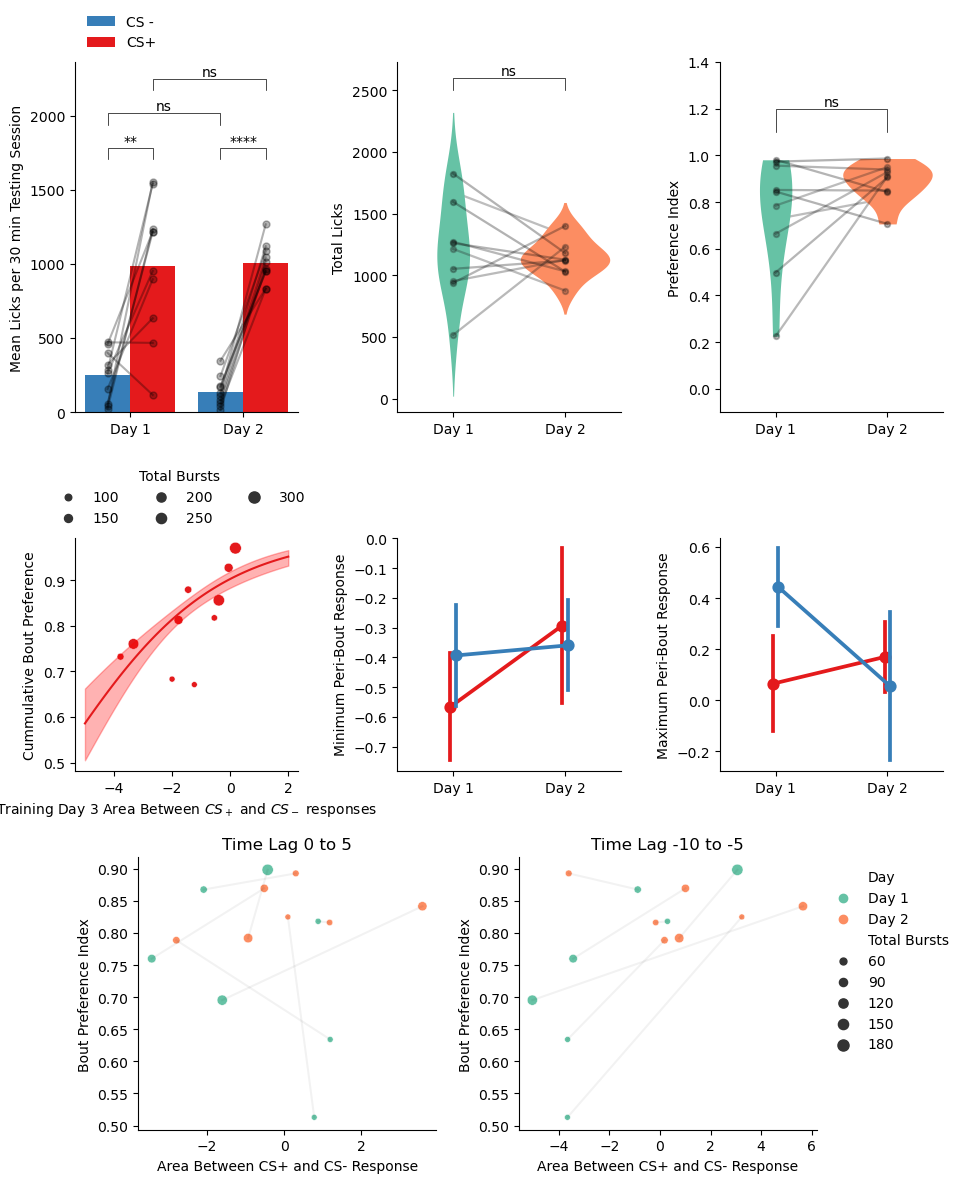

In [260]:
def get_cs_licks(x):
    x = x.iloc[0]
    return pd.Series([x.events['csp'].size, x.events['csm'].size], 
                     index = pd.Index(('+', '-'), name = 'cs'))
def get_cs_bursts(x):
    x = x.iloc[0]
    csp_ili = np.append(1, x.events['csp'][1:] - x.events['csp'][:-1])
    csm_ili = np.append(1, x.events['csm'][1:] - x.events['csm'][:-1])
    return pd.Series([(csp_ili>0.5).sum(), (csm_ili>0.5).sum()], 
                     index = pd.Index(('+', '-'), name = 'cs'))

# get testing licks for plot
licks_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_licks).rename('licks').reset_index().rename(columns = {'cs': 'CS'})
licks_test_d['day'] = licks_test_d.cond.str.split('_',expand = True)[1].astype(int)
licks_test_d = licks_test_d.set_index(['day','mouse','CS']).licks.rename('total_licks')


# get testing bursts
burst_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_bursts).rename('bursts').reset_index().rename(columns = {'cs': 'CS'})
burst_test_d['day'] = burst_test_d.cond.str.split('_',expand = True)[1].astype(int)
burst_test_d = burst_test_d.set_index(['day','mouse','CS']).bursts.rename("bursts")
day_df = pd.concat({'pref': burst_test_d.unstack("CS")['+']/(burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']),
                    'tot': burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']}, axis=1)

cumm_pref = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: x['+']/(x['+']+x['-']), axis=1)
tot = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: (x['+']+x['-']), axis=1)


# get the min from 0-5
mn_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[0:5].idxmin(axis=0)
mn_rp_test_post = {}
for i,v in mn_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp_test_post.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp_test_post = pd.DataFrame(mn_rp_test_post).T
mn_rp_test_post.index = mn_rp_test_post.index.set_names(['day', 'cs'])
mn_rp_test_post = mn_rp_test_post.stack().rename('df')


# get the max from -10- -5
mx_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[-10:-5].idxmax(axis=0)
mx_rp_test = {}
for i,v in mx_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mx_rp_test.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mx_rp_test = pd.DataFrame(mx_rp_test).T
mx_rp_test.index = mx_rp_test.index.set_names(['day', 'cs'])
mx_rp_test= mx_rp_test.stack().rename('df')


# get areas between curves
day_df['abc_10_5'] = (mn_peri_test.T.loc[-10:-5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )
day_df['abc_0_5'] = (mn_peri_test.T.loc[0:5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )



# create subplot
fig,ax = plt.subplots(3,3, figsize = (10,12), gridspec_kw = {'height_ratios': [1.5,1,1]})
# plot testing licks on each day
_, stats_2b  = two_bottle_plot(licks_test_d.loc[2].to_frame(), licks_test_d.loc[1].to_frame(), 
                               groups = ['Day 2', 'Day 1'], ax=ax[0,0], all_paired = True,
                               palette = sns.color_palette('Set1',2))

# plot total testing bursts
tmp = licks_test_d.unstack('CS').sum(axis=1).unstack('day')
ttest_res = st.ttest_rel(tmp[1], tmp[2])
cumm_stat = pd.DataFrame({'paired ttest': list(ttest_res) + [ttest_res.df]}, index= ('t', 'p-value', 'df')).T
tmp = tmp.stack('day').rename('tot').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'tot',
              hue = 'mouse', color='k', ax = ax[0,1], scale= .6)
plt.setp(ax[0,1].lines, alpha=.3)
plt.setp(ax[0,1].collections, alpha=.3)
plot_significance(cumm_stat['p-value'].iloc[0], ax[0,1], 0, 1, 2500, 100 )
sns.violinplot(data = tmp, x = 'day', y = 'tot',  ax = ax[0,1], linewidth=0, saturation = 1, palette = 'Set2')
ax[0,1].get_legend().remove()
ax[0,1].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel("Total Licks")

# plot preference indices on each day
tmp = licks_test_d.unstack('CS')
tmp = tmp['+']/(tmp['+'] + tmp['-'])
tmp = tmp.unstack('day')
pref_stat = pd.DataFrame({'signed rank': st.wilcoxon(tmp[1], tmp[2])}, index= ('W', 'p-value')).T
tmp = tmp.stack('day').rename('pref').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'pref',
              hue = 'mouse', color='k', ax = ax[0,2], scale= .6)
plt.setp(ax[0,2].lines, alpha=.3)
plt.setp(ax[0,2].collections, alpha=.3)
plot_significance(pref_stat['p-value'].iloc[0], ax[0,2], 0, 1, 1.1, .1 )
sns.violinplot(data = tmp, x = 'day', y = 'pref',  ax = ax[0,2], linewidth=0, saturation = 1, palette = 'Set2', cut=0)
ax[0,2].set_ylim([-.1,1.4])
ax[0,2].get_legend().remove()
ax[0,2].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel("Preference Index")


# plot pref vs train day 3 response
df = pd.concat({'preference':cumm_pref ,'training_day3_diff': diff_d3.loc[cumm_pref.index], 'total_bursts': tot})
sns.scatterplot(df, x='training_day3_diff', y='preference', size='total_bursts', ax=ax[1,0])
train_v_pref_model = smf.glm("preference ~ training_day3_diff", data = df, family = sm.families.Binomial(), freq_weights = df.total_bursts).fit()
x = np.linspace(-5, 2, 100)
pred = train_v_pref_model .get_prediction({'training_day3_diff': x})
ax[1,0].plot(x, pred.predicted_mean)
ax[1,0].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1],alpha=0.3, color='red')
ax[1,0].legend(frameon=False, title = 'Total Bursts', ncols=3, bbox_to_anchor=(-.15,1),loc='lower left')
ax[1,0].set(ylabel=r"Cummulative Bout Preference", xlabel="Training Day 3 Area Between $CS_+$ and $CS_-$ responses")



# plot minimum peri response on each day
sns.pointplot(mn_rp_test_post.reset_index(), x='day', y='df',hue='cs',errorbar='se',dodge=True, ax=ax[1,1])
ax[1,1].get_legend().remove()
ax[1,1].set_ylabel("Minimum Peri-Bout Response")
ax[1,1].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[1,1].set_xlabel("")


# plot maximum peri response on each day
sns.pointplot(mx_rp_test.reset_index(), x='day', y='df',hue='cs',errorbar='se',dodge=True, ax=ax[1,2])
ax[1,2].get_legend().remove()
ax[1,2].set_ylabel("Maximum Peri-Bout Response")
ax[1,2].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[1,2].set_xlabel("")


# plot pref vs difference in cs+ and cs- tuning on each day
fig.tight_layout(pad = 2.)
ax[2,0].remove()
ax[2,1].remove()
ax[2,2].remove()
 
from matplotlib.gridspec import GridSpec
gs = GridSpec(3,14)
ax = fig.add_subplot(gs[2,1:6])

_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Bursts'})
sns.lineplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Bursts')

h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_title("Time Lag 0 to 5")
ax.set_xlabel(r"Area Between CS+ and CS- Response")
ax.set_ylabel("Bout Preference Index")

ax = fig.add_subplot(gs[2,7:12])
_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Bursts'})
sns.lineplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Bursts')

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, frameon = False, loc = 'upper left', bbox_to_anchor = (1,1))
ax.set_title("Time Lag -10 to -5")
ax.set_xlabel(r"Area Between CS+ and CS- Response")
ax.set_ylabel("Bout Preference Index")

# format the figure
sns.despine()


# # save the figure
fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_pref_quant.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_pref_quant.svg'))

#### stats

##### stats - 2 bottle stats

In [242]:
shapiro = (licks_test_d.groupby(['day','CS'])
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
anova_res = AnovaRM(licks_test_d.reset_index(), 'total_licks',  'mouse', within = ['CS','day']).fit().summary().tables[0]
anova_res['Significance'] = anova_res['Pr > F'].apply(check_significance)
stats_2b = stats_2b.rename(columns = {'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value', 'statistic': 't'})
stats_2b['Significance'] = stats_2b['Corrected p-value'].apply(check_significance)
display(shapiro, anova_res, stats_2b)

main_test_fig_stats.update({'c_test_anova_g'   : anova_res,
                            'c_test_posthoc_g' : stats_2b})

statistic   p-value
day CS                     
1   +    0.940022  0.553258
    -    0.911298  0.290025
2   +    0.952753  0.701120
    -    0.939929  0.552225

F Value  Num DF  Den DF    Pr > F Significance
CS      99.441374     1.0     9.0  0.000004         ****
day      0.380288     1.0     9.0  0.552727           ns
CS:day   0.365626     1.0     9.0  0.560332           ns

t       p-value  Corrected p-value  paired  \
CS+ vs. CS- Day 2        15.332651  9.322911e-08       3.729164e-07    True   
CS+ vs. CS- Day 1         3.998025  3.119711e-03       9.329965e-03    True   
CS+ Day 2 vs. CS+ Day 1   0.134968  8.956077e-01       8.956077e-01    True   
CS- Day 2 vs. CS- Day 1  -2.035855  7.224756e-02       1.392754e-01    True   

                        Significance  
CS+ vs. CS- Day 2               ****  
CS+ vs. CS- Day 1                 **  
CS+ Day 2 vs. CS+ Day 1           ns  
CS- Day 2 vs. CS- Day 1           ns

##### stats - cummulative licks comparison

In [243]:
cumm_stat['Significance'] = cumm_stat['p-value'].apply(check_significance)
display(cumm_stat)
main_test_fig_stats.update({'d_cumm_licks_d1v2': cumm_stat})

t   p-value   df Significance
paired ttest  0.616675  0.552727  9.0           ns

##### stats - preference comparison

In [244]:
pref_stat['Significance'] = pref_stat['p-value'].apply(check_significance)
display(pref_stat)
main_test_fig_stats.update({'e_pref_d1v2': pref_stat})

W   p-value Significance
signed rank  15.0  0.232422           ns

##### stats - training area between curves vs preference

In [245]:
train_v_pref = pd.DataFrame(train_v_pref_model.summary().tables[1]).astype(str)
train_v_pref.columns = train_v_pref.iloc[0].astype(str)
train_v_pref[''] = train_v_pref[''].astype(str)
train_v_pref = train_v_pref.iloc[1:].set_index('').astype(float)
train_v_pref['Significance'] = train_v_pref['P>|z|'].apply(check_significance)
display(train_v_pref)
main_test_fig_stats.update({'f_pref_v_train_abc_d3': min_stats})

0                     coef  std err       z  P>|z|  [0.025  0.975]  \
                                                                     
Intercept           2.2250    0.103  21.520    0.0   2.022   2.428   
training_day3_diff  0.3757    0.047   8.073    0.0   0.285   0.467   

0                  Significance  
                                 
Intercept                  ****  
training_day3_diff         ****

##### stats - minimum comparison

In [246]:
min_stats = pd.concat({'CS+ vs CS-': mn_rp_test_post.unstack('cs')
                                                    .groupby('day')
                                                    .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                    .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                    .reset_index(),
                       'Day 1 vs Day 2': mn_rp_test_post.unstack('day')
                                                        .groupby('cs')
                                                        .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                        .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                        .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
min_stats['Corrected p-value'] = multipletests(min_stats['p-value'], method = 'holm-sidak')[1]
min_stats['Significance'] = min_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'g_min_resp_d1v2': min_stats})
display(min_stats)

Comparison  day         t   p-value   df   cs  Corrected p-value  \
0      CS+ vs CS-  1.0 -1.143505  0.296393  6.0  NaN           0.754912   
1      CS+ vs CS-  2.0  0.285814  0.784632  6.0  NaN           0.953616   
2  Day 1 vs Day 2  NaN -0.834057  0.436189  6.0    +           0.820775   
3  Day 1 vs Day 2  NaN -0.167043  0.872824  6.0    -           0.953616   

  Significance  
0           ns  
1           ns  
2           ns  
3           ns

##### stats - mean comparison

In [247]:
mean_stats = pd.concat({'CS+ vs CS-': mx_rp_test.unstack('cs')
                                                .groupby('day')
                                                .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                .reset_index(),
                       'Day 1 vs Day 2': mx_rp_test.unstack('day')
                                                   .groupby('cs')
                                                   .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                   .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                   .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
mean_stats['Corrected p-value'] = multipletests(mean_stats['p-value'], method = 'holm-sidak')[1]
mean_stats['Significance'] = mean_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'h_mean_resp_d1v2': mean_stats})
display(mean_stats)

Comparison  day         t   p-value   df   cs  Corrected p-value  \
0      CS+ vs CS-  1.0 -1.485180  0.188037  6.0  NaN           0.565346   
1      CS+ vs CS-  2.0  0.476799  0.650374  6.0  NaN           0.760598   
2  Day 1 vs Day 2  NaN -0.769346  0.470880  6.0    +           0.760598   
3  Day 1 vs Day 2  NaN  0.949408  0.379070  6.0    -           0.760598   

  Significance  
0           ns  
1           ns  
2           ns  
3           ns

##### stats - pref v diff model

In [248]:
df = day_df.reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')



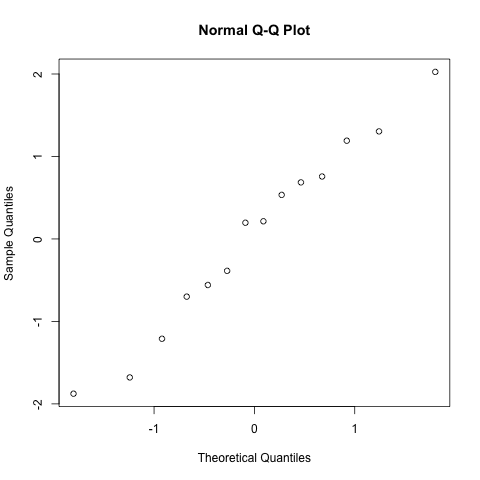

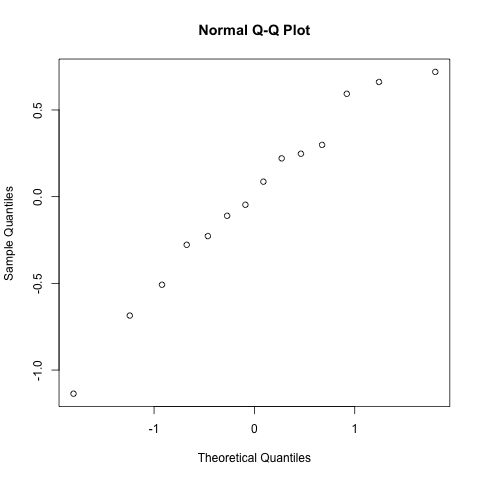

In [251]:
%%R -i df -o abc_0_5_model -o abc_10_5_model
m <- glmer('pref ~ 1 + abc_0_5*factor(day)  + (1 + abc_0_5|mouse)', data = df, weights = tot, family = 'binomial')
abc_0_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

m <- glmer('pref ~ 1 + abc_10_5*factor(day)  + (1 + abc_10_5|mouse)', data = df, weights = tot, family = 'binomial')
abc_10_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

In [252]:
abc_0_5_model['Significance'] = abc_0_5_model['Pr(>|z|)'].apply(check_significance)
abc_10_5_model['Significance'] = abc_10_5_model['Pr(>|z|)'].apply(check_significance)

display(abc_0_5_model, abc_10_5_model)

main_test_fig_stats.update({'i_abc_0_5_v_pref': abc_0_5_model,
                            'j_abc_10_5_v_pref': abc_10_5_model})

Estimate  Std. Error   z value      Pr(>|z|)  \
(Intercept)           1.272318    0.252240  5.044072  4.557271e-07   
abc_0_5              -0.008285    0.125259 -0.066145  9.472623e-01   
factor(day)2          0.301242    0.315237  0.955602  3.392733e-01   
abc_0_5:factor(day)2  0.184455    0.183145  1.007150  3.138626e-01   

                     Significance  
(Intercept)                  ****  
abc_0_5                        ns  
factor(day)2                   ns  
abc_0_5:factor(day)2           ns

Estimate  Std. Error    z value      Pr(>|z|)  \
(Intercept)            1.587147    0.156335  10.152242  3.238370e-24   
abc_10_5               0.211345    0.049212   4.294620  1.749927e-05   
factor(day)2          -0.013751    0.188188  -0.073071  9.417498e-01   
abc_10_5:factor(day)2 -0.202020    0.077451  -2.608367  9.097532e-03   

                      Significance  
(Intercept)                   ****  
abc_10_5                      ****  
factor(day)2                    ns  
abc_10_5:factor(day)2           **

In [253]:
with pd.ExcelWriter('stats/raw/testing_stats.xlsx') as writer:  
    for k,v in main_test_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within day

In [261]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()
peri_test_binned['bout_fraction'] = peri_test_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
day1_test_binned = peri_test_binned.loc[peri_test_binned.day==1]

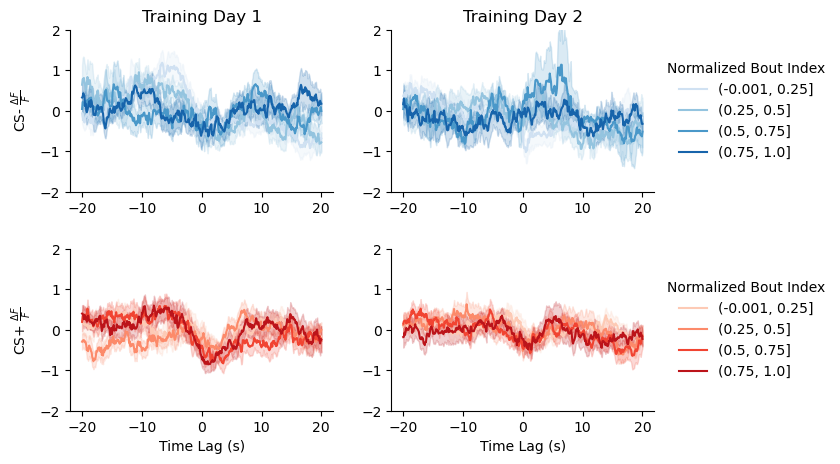

In [262]:
fig, ax = plt.subplots(2,2, figsize=(7,5))

df = peri_test.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(2):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<1 else True)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<1 else True)
    ax[0,i].set_ylim(-2,2)
    ax[1,i].set_ylim(-2,2)
    ax[0,i].set_title(f"Training Day {i+1}")
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)")

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$")
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$")
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")

fig.savefig(os.path.join(peri_stim_pdfs_test ,'supp_test_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'supp_test_within_sessiont.svg'))

#### stats

R[write to console]: boundary (singular) fit: see help('isSingular')



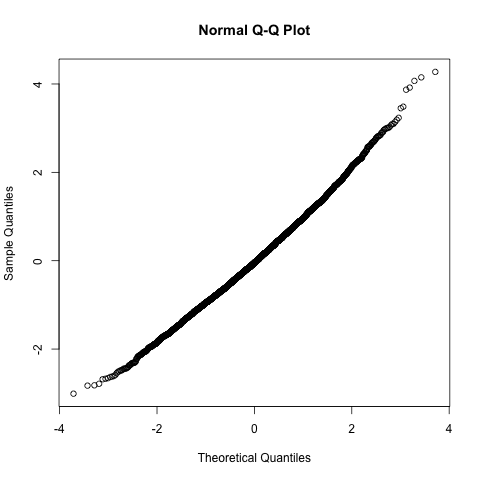

In [164]:
%%R -i day1_test_binned -o day1_test_anova -o day1_test_model
m <- lmer('df ~ 1+ bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_test_binned)
day1_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_test_anova <- anova(m)

In [165]:
day1_test_anova['Significance'] = day1_test_anova['Pr(>F)'].apply(check_significance)
day1_test_model['Significance'] = day1_test_model['Pr(>|t|)'].apply(check_significance)

display(day1_test_anova, day1_test_model)


supp_test_fig_peri_stats = {'day1_peri_bout_anovas': day1_test_anova,
                             'day1_peri_bout_stat':   day1_test_model}

Sum Sq    Mean Sq  \
bout_fraction                                         2.807084   2.807084   
factor(cs)                                            0.162564   0.162564   
bs(bins, df = 8, degree = 3)                         55.282630   6.910329   
bout_fraction:factor(cs)                              0.008861   0.008861   
bout_fraction:bs(bins, df = 8, degree = 3)           35.589146   4.448643   
factor(cs):bs(bins, df = 8, degree = 3)             139.120275  17.390034   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  116.206014  14.525752   

                                                    NumDF        DenDF  \
bout_fraction                                           1  4853.131032   
factor(cs)                                              1  4804.402577   
bs(bins, df = 8, degree = 3)                            8    27.255593   
bout_fraction:factor(cs)                                1  4853.128946   
bout_fraction:bs(bins, df = 8, degree = 3)              8  4853.131636   
factor(cs):bs(bins, df = 8, degree = 3)                 8  4772.710032   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  4853.131301   

                                                      F value        Pr(>F)  \
bout_fraction                                        2.884785  8.948403e-02   
factor(cs)                                           0.167064  6.827528e-01   
bs(bins, df = 8, degree = 3)                         7.101609  4.655825e-05   
bout_fraction:factor(cs)                             0.009106  9.239819e-01   
bout_fraction:bs(bins, df = 8, degree = 3)           4.571783  1.446416e-05   
factor(cs):bs(bins, df = 8, degree = 3)             17.871397  1.498322e-26   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  14.927830  8.375915e-22   

                                                   Significance  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                               ****  
bout_fraction:factor(cs)                                     ns  
bout_fraction:bs(bins, df = 8, degree = 3)                 ****  
factor(cs):bs(bins, df = 8, degree = 3)                    ****  
bout_fraction:factor(cs):bs(bins, df = 8, degre...         ****

Estimate  Std. Error  \
(Intercept)                                        -0.055067    0.254522   
bout_fraction                                       0.460212    0.400381   
factor(cs)+                                        -0.125989    0.308242   
bs(bins, df = 8, degree = 3)1                       0.491276    0.467617   
bs(bins, df = 8, degree = 3)2                      -0.186027    0.396173   
bs(bins, df = 8, degree = 3)3                       1.888838    0.398214   
bs(bins, df = 8, degree = 3)4                      -0.640274    0.451568   
bs(bins, df = 8, degree = 3)5                      -0.183132    0.385684   
bs(bins, df = 8, degree = 3)6                      -0.414469    0.417854   
bs(bins, df = 8, degree = 3)7                      -1.059105    0.422442   
bs(bins, df = 8, degree = 3)8                      -0.817911    0.363562   
bout_fraction:factor(cs)+                          -0.048961    0.513088   
bout_fraction:bs(bins, df = 8, degree = 3)1        -1.240805    0.772626   
bout_fraction:bs(bins, df = 8, degree = 3)2         0.150602    0.589906   
bout_fraction:bs(bins, df = 8, degree = 3)3        -2.214357    0.621141   
bout_fraction:bs(bins, df = 8, degree = 3)4        -0.530595    0.549304   
bout_fraction:bs(bins, df = 8, degree = 3)5         0.390071    0.598755   
bout_fraction:bs(bins, df = 8, degree = 3)6        -0.137671    0.651968   
bout_fraction:bs(bins, df = 8, degree = 3)7         1.205685    0.663282   
bout_fraction:bs(bins, df = 8, degree = 3)8         0.627097    0.565208   
factor(cs)+:bs(bins, df = 8, degree = 3)1          -0.377430    0.594089   
factor(cs)+:bs(bins, df = 8, degree = 3)2           0.578750    0.455402   
factor(cs)+:bs(bins, df = 8, degree = 3)3          -2.061696    0.478290   
factor(cs)+:bs(bins, df = 8, degree = 3)4           0.616591    0.423838   
factor(cs)+:bs(bins, df = 8, degree = 3)5           0.274526    0.461017   
factor(cs)+:bs(bins, df = 8, degree = 3)6           0.963416    0.502345   
factor(cs)+:bs(bins, df = 8, degree = 3)7           0.806808    0.510293   
factor(cs)+:bs(bins, df = 8, degree = 3)8           1.049797    0.435165   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  1.165587    0.990119   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.327551    0.755964   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  3.493738    0.795991   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.852607    0.703932   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.708804    0.767304   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.688988    0.835497   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.342172    0.849995   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.450120    0.724313   

                                                             df   t value  \
(Intercept)                                          196.675625 -0.216353   
bout_fraction                                       4853.129612  1.149434   
factor(cs)+                                         4804.402577 -0.408734   
bs(bins, df = 8, degree = 3)1                       4070.926513  1.050595   
bs(bins, df = 8, degree = 3)2                         80.027980 -0.469561   
bs(bins, df = 8, degree = 3)3                        261.241346  4.743272   
bs(bins, df = 8, degree = 3)4                         22.629390 -1.417890   
bs(bins, df = 8, degree = 3)5                        162.343238 -0.474824   
bs(bins, df = 8, degree = 3)6                        166.495664 -0.991900   
bs(bins, df = 8, degree = 3)7                        204.724865 -2.507103   
bs(bins, df = 8, degree = 3)8                        163.475395 -2.249716   
bout_fraction:factor(cs)+                           4853.128946 -0.095424   
bout_fraction:bs(bins, df = 8, degree = 3)1         4853.130945 -1.605958   
bout_fraction:bs(bins, df = 8, degree = 3)2         4853.130509  0.255298   
bout_fraction:bs(bins, df = 8, degree = 3)3         4853.131079 -3.564985   
bout_fr

R[write to console]: boundary (singular) fit: see help('isSingular')



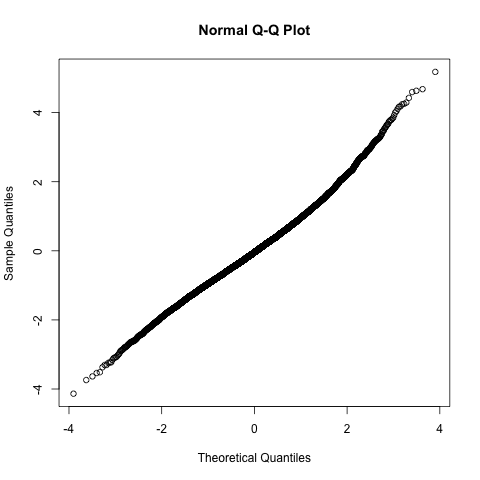

In [166]:
%%R -i peri_test_binned -o peri_within_test_anova -o peri_within_test_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_test_binned)
peri_within_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_test_anova <- anova(m)

In [ ]:
peri_within_test_anova['Significance'] = peri_within_test_anova['Pr(>F)'].apply(check_significance)
peri_within_test_model['Significance'] = peri_within_test_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_test_anova, peri_within_test_model)

supp_test_fig_peri_stats.update({'peri_within_anova': peri_within_test_anova,
                                  'peri_within_model': peri_within_test_model
                                  })

Sum Sq    Mean Sq  \
factor(day)                                          2.495942   2.495942   
bout_fraction                                        0.498089   0.498089   
factor(cs)                                           0.900631   0.900631   
bs(bins, df = 8, degree = 3)                        29.470413   3.683802   
factor(day):bout_fraction                            2.868886   2.868886   
factor(day):factor(cs)                               0.189724   0.189724   
bout_fraction:factor(cs)                             0.231803   0.231803   
factor(day):bs(bins, df = 8, degree = 3)            17.615426   2.201928   
bout_fraction:bs(bins, df = 8, degree = 3)          50.763081   6.345385   
factor(cs):bs(bins, df = 8, degree = 3)             90.079209  11.259901   
factor(day):bout_fraction:factor(cs)                 0.379791   0.379791   
factor(day):bout_fraction:bs(bins, df = 8, degr...  34.808366   4.351046   
factor(day):factor(cs):bs(bins, df = 8, degree ...  79.413711   9.926714   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  82.246662  10.280833   
factor(day):bout_fraction:factor(cs):bs(bins, d...  57.025858   7.128232   

                                                    NumDF         DenDF  \
factor(day)                                             1  10391.925288   
bout_fraction                                           1  10393.474071   
factor(cs)                                              1  10357.948961   
bs(bins, df = 8, degree = 3)                            8     17.722239   
factor(day):bout_fraction                               1  10393.472474   
factor(day):factor(cs)                                  1  10359.731922   
bout_fraction:factor(cs)                                1  10393.446337   
factor(day):bs(bins, df = 8, degree = 3)                8  10390.520099   
bout_fraction:bs(bins, df = 8, degree = 3)              8  10393.477452   
factor(cs):bs(bins, df = 8, degree = 3)                 8  10290.112542   
factor(day):bout_fraction:factor(cs)                    1  10393.302234   
factor(day):bout_fraction:bs(bins, df = 8, degr...      8  10393.477255   
factor(day):factor(cs):bs(bins, df = 8, degree ...      8  10297.344295   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  10393.474317   
factor(day):bout_fraction:factor(cs):bs(bins, d...      8  10393.459474   

                                                      F value        Pr(>F)  \
factor(day)                                          2.421275  1.197280e-01   
bout_fraction                                        0.483188  4.869971e-01   
factor(cs)                                           0.873688  3.499581e-01   
bs(bins, df = 8, degree = 3)                         3.573600  1.213343e-02   
factor(day):bout_fraction                            2.783063  9.529596e-02   
factor(day):factor(cs)                               0.184048  6.679262e-01   
bout_fraction:factor(cs)                             0.224869  6.353647e-01   
factor(day):bs(bins, df = 8, degree = 3)             2.136057  2.929337e-02   
bout_fraction:bs(bins, df = 8, degree = 3)           6.155561  5.970509e-08   
factor(cs):bs(bins, df = 8, degree = 3)             10.923058  1.851446e-15   
factor(day):bout_fraction:factor(cs)                 0.368429  5.438750e-01   
factor(day):bout_fraction:bs(bins, df = 8, degr...   4.220883  4.561761e-05   
factor(day):factor(cs):bs(bins, df = 8, degree ...   9.629753  2.175573e-13   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   9.973278  6.150687e-14   
factor(day):bout_fraction:factor(cs):bs(bins, d...   6.914989  4.056580e-09   

                                                   Significance  
factor(day)                                                  ns  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                                  *  
factor(day):bout_fraction                 

Estimate  Std. Error  \
(Intercept)                                        -0.058485    0.253191   
factor(day)2                                        0.439691    0.355017   
bout_fraction                                       0.460212    0.412096   
factor(cs)+                                        -0.112033    0.316937   
bs(bins, df = 8, degree = 3)1                       0.487482    0.489014   
...                                                      ...         ...   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -1.122714    1.011780   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.764088    1.102866   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -1.144720    1.200881   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  1.196098    1.221719   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  1.311598    1.041074   

                                                              df   t value  \
(Intercept)                                          1344.460997 -0.230994   
factor(day)2                                        10376.969847  1.238506   
bout_fraction                                       10393.309906  1.116760   
factor(cs)+                                         10369.564740 -0.353487   
bs(bins, df = 8, degree = 3)1                        1065.864590  0.996869   
...                                                          ...       ...   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  10393.428678 -1.109643   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  10393.440291  0.692820   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  10393.424017 -0.953233   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  10393.462716  0.979029   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  10393.421440  1.259851   

                                                    Pr(>|t|) Significance  
(Intercept)                                         0.817355           ns  
factor(day)2                                        0.215557           ns  
bout_fraction                                       0.264123           ns  
factor(cs)+                                         0.723730           ns  
bs(bins, df = 8, degree = 3)1                       0.319054           ns  
...                                                      ...          ...  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.267179           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.488438           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.340494           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.327589           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.207752           ns  

[72 rows x 6 columns]

In [231]:
with pd.ExcelWriter('stats/raw/supp_test_peri_stats.xlsx') as writer:  
    for k,v in supp_test_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)